# 02_MARES_mooring_DATA-Analysis

### Import packages

In [644]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../')
import plot_simply.geomap as geomap
import timeseries.vectors as vectors
import data_UniBremen.SIC as UNISIC


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def grab_atm(time_range, lat = 70.5 , lon = -140):
    
    # year1
    DS1 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.start.year}.nc')
    DS1.close()
    time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
    DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)

    # year2
    DS2 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.stop.year}.nc')
    DS2.close()
    time_slice = slice(datetime(time_range.stop.year, 1, 1, 0), time_range.stop)
    DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_slice)

    # combine
    ds4 = xr.concat([DS1, DS2], dim="time")
    
    return ds4
    

## Import data

In [3]:
# Save to file
df = pd.read_csv('./data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>}

<IPython.core.display.Javascript object>


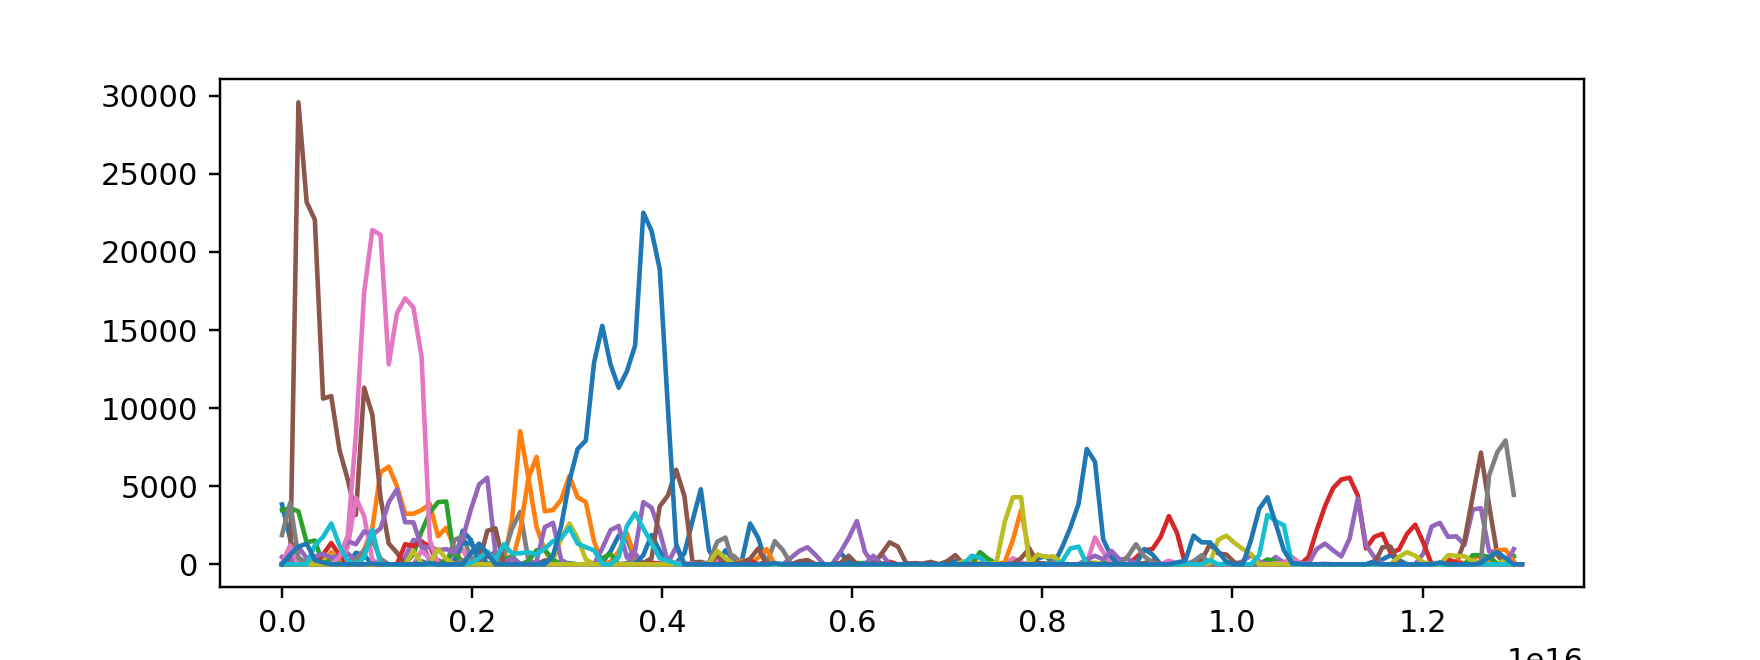

In [614]:
years = np.append(np.arange(2003,2016), np.arange(2017,2025))

fig, ax= plt.subplots(figsize=(8,3))


for year in years:
    
    time_range = slice(datetime(year-1, 12, 1), datetime(year, 4, 30,23))
    open_years = f'{time_range.start.year}_{time_range.stop.year}'
    DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_v0.nc')
    DS = DS.sel(time = time_range)
    
    plt.plot((DS.time - DS.time[0]), DS.extent)

In [1671]:
#===============================================================

# 2016-2017
# time_range = slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23))

# 2017-2018
time_range = slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))

# 2018-2019
# time_range = slice(datetime(2018, 12, 1), datetime(2019, 4, 30,23))

#===============================================================

#=============
mooring = 'M1'
#=============

open_years = f'{time_range.start.year}_{time_range.stop.year}'

# calculate projected ESE current component
# u_val = np.cos(157.5 * np.pi/180)
# v_val = np.sin(157.5 * np.pi/180)

DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_v0.nc')
DS = DS.sel(time = time_range)
# DS['length'] = DS['l_max'] - DS['l_min']


# ocean velocity
#-----------------
ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 135*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+135)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# ocean temperature, sailinity
#-----------------------------
ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)

ds2['dT'] = ds2.Ct - ds2.Tf

# sea ice velocity
#------------------
ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
ds3.close()
ds3 = ds3.sel(depth=0, time=time_range)
ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 135*units('deg'))
ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)


icespeed = np.sqrt(ds3.u**2 + ds3.v**2)

u_sfc = ds3.u.values
v_sfc = ds3.v.values

scf_angle = vectors.vector_angle(u_sfc, v_sfc)



# u_norm = u_sfc / icespeed
# v_norm = v_sfc / icespeed

# u_perp = - v_norm
# v_perp = u_norm

along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))


lat, lon = 70.5, -140 
ds4 = grab_atm(time_range, lat = lat, lon = lon)
ds4['speed'] = np.sqrt(ds4.u10**2+ ds4.v10**2)
ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))
# wind_along_sfc = (ds4.u10 * u_norm) + (ds4.v10 * v_norm)
# wind_perp_sfc = (ds4.u10 * -v_norm) + (ds4.v10 * u_norm)


In [1672]:
DS['length'] = (DS['l_per95'] - DS['l_per5'])

# DS['length'] = DS['extent'] / (DS['w_max'] - DS['w_min'])
# DS['length'][np.where(DS['extent'] == 0)[0]] = 0

In [518]:
wind_angle = vectors.vector_angle(ds4.u10.values, ds4.v10.values)
wind_speed = np.sqrt(ds4.u10.values**2 + ds4.v10.values**2)

wf = 0.015 * 10
ta = 20*units('deg')

exp_ice_u = wf * wind_speed * np.cos(wind_angle + ta)
exp_ice_v = wf * wind_speed * np.sin(wind_angle + ta)

exp_ice_se = vectors.comp_along_theta(exp_ice_u, exp_ice_v, 135*units('deg'))




In [712]:
open_times = np.array([], dtype='datetime64[ns]')
for time in pd.to_datetime(DS.time.values[DS.extent>0]):
    fullday = pd.date_range(time, time+timedelta(hours=23), freq='1H')
    open_times = np.append(open_times, fullday)
    
clos_times = np.array([], dtype='datetime64[ns]')
for time in pd.to_datetime(DS.time.values[DS.extent==0]):
    fullday = pd.date_range(time, time+timedelta(hours=23), freq='1H')
    clos_times = np.append(clos_times, fullday)

<IPython.core.display.Javascript object>


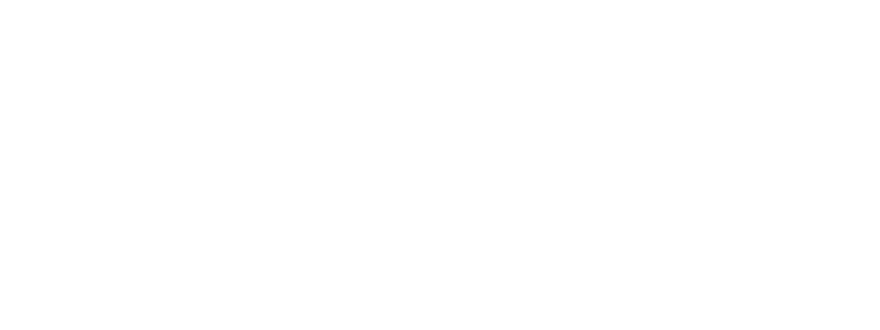

<IPython.core.display.Javascript object>


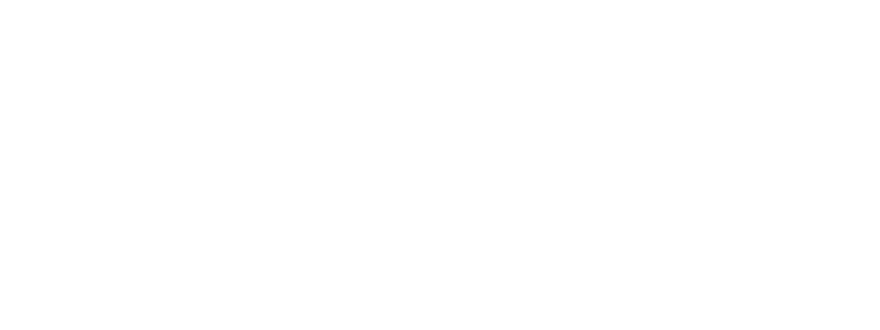

<IPython.core.display.Javascript object>


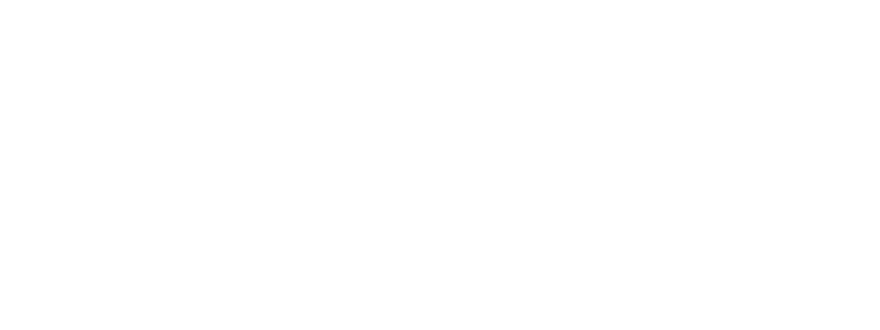

<IPython.core.display.Javascript object>


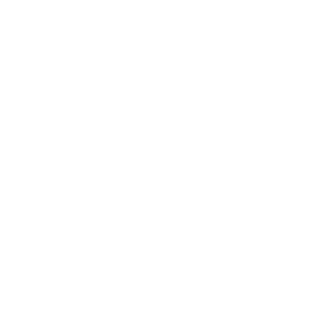

<IPython.core.display.Javascript object>


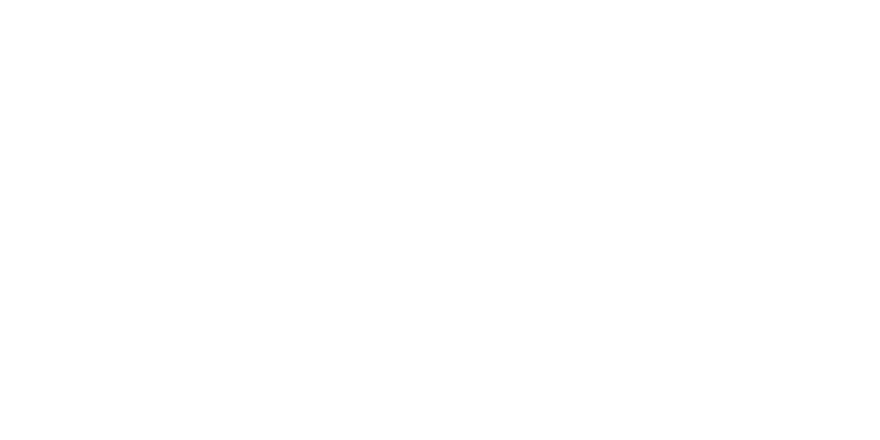

<IPython.core.display.Javascript object>


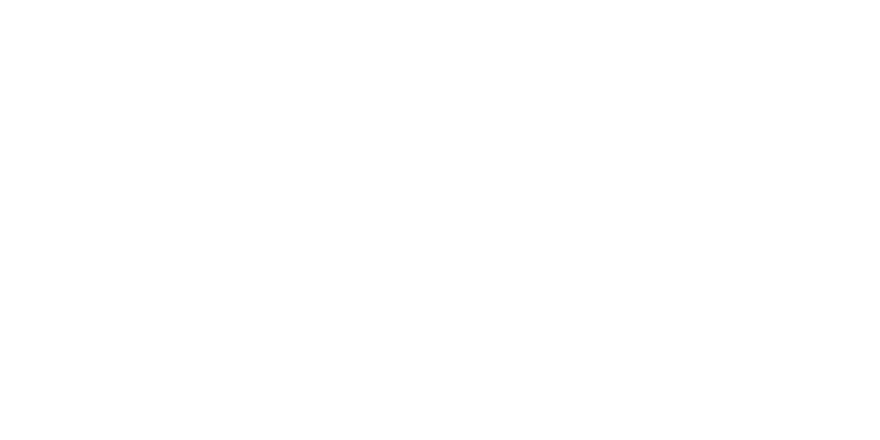

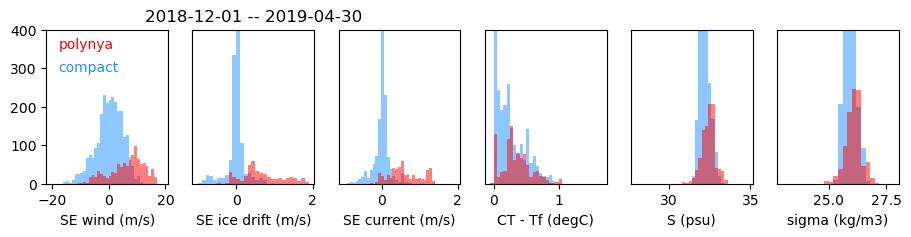

In [713]:
%matplotlib inline

fig, axs = plt.subplots(1,6, figsize=(11,2))

ax = axs[0]
ax.set_xlabel('SE wind (m/s)')
ax.set_ylim(0,400)
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds4.se.sel(time = event), bins=np.arange(-20,20,1), color=color, alpha=0.5)

ax = axs[1]
ax.set_xlabel('SE ice drift (m/s)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds3.se.sel(time = event), bins=np.arange(-1,2,0.1), color=color, alpha=0.5)
    
ax.set_title(f"{time_range.start.date()} -- {time_range.stop.date()}")
ax = axs[2]
ax.set_xlabel('SE current (m/s)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds.se.mean(dim='depth').sel(time = event), bins=np.arange(-1,2,0.075), color=color, alpha=0.5) 
    
ax = axs[3]
ax.set_xlabel('CT - Tf (degC)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.dT.sel(depth=-16).sel(time = event), bins=np.arange(-0.05,1.7,0.05), color=color, alpha=0.5)
    
ax = axs[4]
ax.set_xlabel('S (psu)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.Sp.sel(depth=-16).sel(time = event), bins=np.arange(28,35,0.2), color=color, alpha=0.5)
    
ax = axs[5]
ax.set_xlabel('sigma (kg/m3)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.sig0.sel(depth=-16).sel(time = event), bins=np.arange(23,28,0.2), color=color, alpha=0.5)
    
ax = axs[0]
ax.text(0.1,0.95,'polynya', c='red', ha='left', va='top',transform=ax.transAxes)
ax = axs[0]
ax.text(0.1,0.8,'compact', c='dodgerblue', ha='left', va='top',transform=ax.transAxes)
    
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

In [524]:
dLdt = DS.length.diff('time')
dttimes = pd.to_datetime(dLdt.time.values)# - timedelta(hours=12)

L = DS.length.values[:-1]

In [525]:
ui = np.array([])
ua = np.array([])

for time in dttimes:
    
    time_slice = slice(time - timedelta(hours=12), time + timedelta(hours=11))
    
    avg_ui = ds3.se.sel(time = time_slice).mean(dim='time').values * units('m/s')
    avg_ua = ds4.se.sel(time = time_slice).mean(dim='time').values * units('m/s')
    
    ui = np.append(ui, avg_ui.to('km/day').magnitude)
    ua = np.append(ua, avg_ua.to('m/s').magnitude)

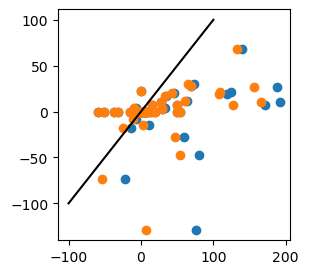

In [526]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3,3))

line = 100

frazil_collection = 50 # km/day

ht = (1/15) * (1+0.1*np.abs(ua))
# ht[np.abs(ua)<5] = 0
P = 0.05
frazil_collection = P*L/ht # km/day


ax.plot([-line,line], [-line, line], c='k')

ax.scatter(ui, dLdt)
ax.scatter(ui-frazil_collection, dLdt)

# ax.scatter(ua, ht)

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,3))


# ax.bar(dttimes, dLdt/20, align='edge')

ax.plot(dttimes, dLdt, c='b', marker='.')


# ax.plot(dttimes, dLdt)
# ax.scatter(dLdt.time, np.zeros(len(dLdt)), marker='.')

ax.plot(dLdt.time, ui, marker='.', c='lightgray')
ax.plot(dLdt.time, ui-frazil_collection, marker='.', c='gray')

ax.plot(ds3.time, ds3.se, c='k')

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,3))


# ax.bar(dttimes, dLdt/20, align='edge')

ax.plot(dttimes, dLdt, c='b', marker='.')


# ax.plot(dttimes, dLdt)
# ax.scatter(dLdt.time, np.zeros(len(dLdt)), marker='.')

ax.plot(dLdt.time, ui, marker='.', c='lightgray')
ax.plot(dLdt.time, ui-frazil_collection, marker='.', c='gray')

ax.plot(ds3.time, ds3.se, c='k')

<IPython.core.display.Javascript object>


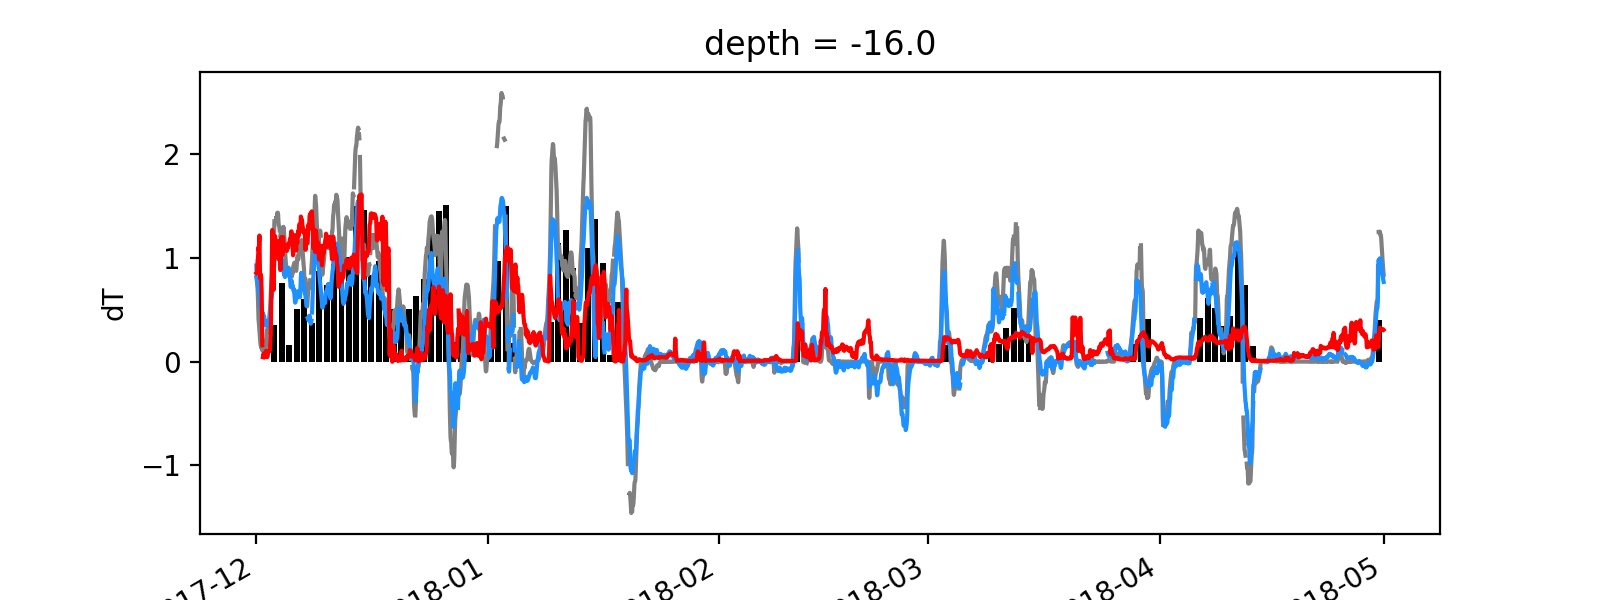

<BarContainer object of 151 artists>

In [135]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,3))
# plt.plot(ds3.time, exp_ice_se, c='lightgray')
# plt.plot(ds.time, exp_ice_se, c='k')
(ds3.se).plot(c='gray')

(ds.se.sel(depth=-10)).plot(c='dodgerblue')

(ds2.dT.sel(depth=-16)).plot(c='r')


# plt.bar(DS.time, DS.extent/2000, align='edge', color='k')

plt.bar(DS.time, (DS.length)/50, align='edge', color='k')



# (ds.u.sel(depth=-22)).plot()

# ds2.dT.sel(depth=-16).plot()
# plt.ylim(-0.2,0.2)
# ds32.u.plot()

<IPython.core.display.Javascript object>


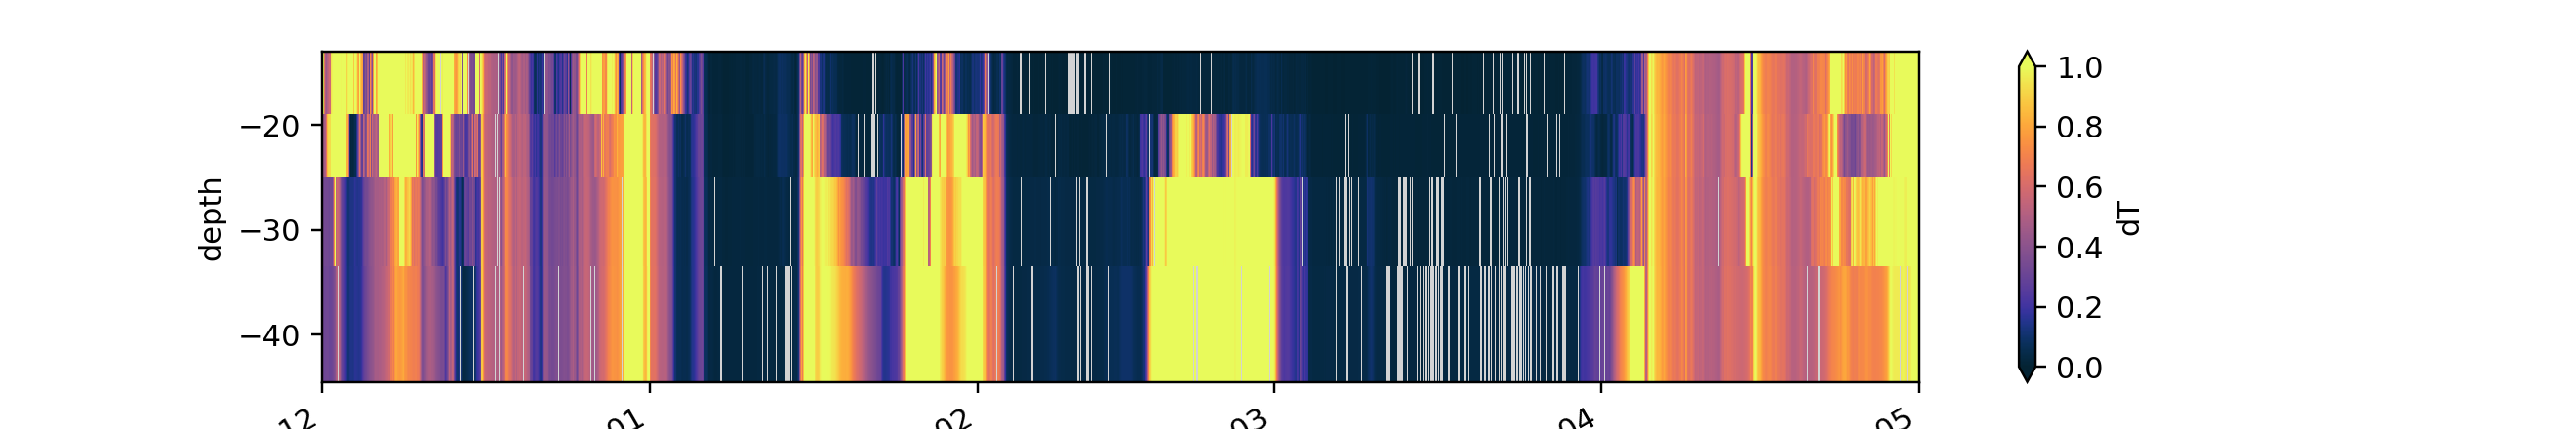

<xarray.DataArray 'depth' (depth: 4)>
array([-39., -28., -22., -16.])
Coordinates:
  * depth    (depth) float64 -39.0 -28.0 -22.0 -16.0


In [404]:


fig, ax = plt.subplots(figsize=(12,2))
ax.patch.set_facecolor('lightgray')


(ds2.dT).plot(vmin=0, vmax=1, cmap=cmocean.cm.thermal)

# .sel(depth = np.array([-36,-28,-16]))
# ds2.Sp.plot(vmin=30, vmax=34, cmap=cmocean.cm.thermal)

print(ds2.depth)


# ax.plot(ds3.time, 8*(-ds3.u)-16,c='r',  clip_on = True)
# ax.plot(ds.time, 8*(-ds.u.mean(dim='depth'))-16,c='mediumpurple',  clip_on = True)

# ax.set_xlim(datetime(2017,2,15), datetime(2017,3,5))

### Evaluate data gaps

In [527]:
#===================
retain_frac = 0.95
#===================

print(f'Ocean currents:')
for depth in ds.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds.u.sel(depth=depth).values)) / len(ds.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

print(f'\nOcean temperatures:')
for depth in ds2.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds2.Ct.sel(depth=depth).values)) / len(ds2.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
    
print(f'\nSea ice velocity:')
# finite fraction
ffrac = np.sum(np.isfinite(ds3.u.values)) / len(ds3.time)
print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

Ocean currents:
z = -4.0 [0.30] 
z = -6.0 [0.42] 
z = -8.0 [0.46] 
z = -10.0 [0.48] 
z = -12.0 [0.48] 
z = -14.0 [0.48] 
z = -18.0 [0.47] 
z = -22.0 [0.00] 
z = -24.0 [0.36] 
z = -30.0 [0.48] 

Ocean temperatures:
z = -16.0 [1.00] *
z = -22.0 [1.00] *
z = -28.0 [1.00] *
z = -36.0 [0.99] *

Sea ice velocity:
z = -36.0 [0.47] 


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/1511898339.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/1511898339.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/1511898339.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')


layer 0 [0, -16], dz = 16 meter


ValueError: attempt to get argmin of an empty sequence

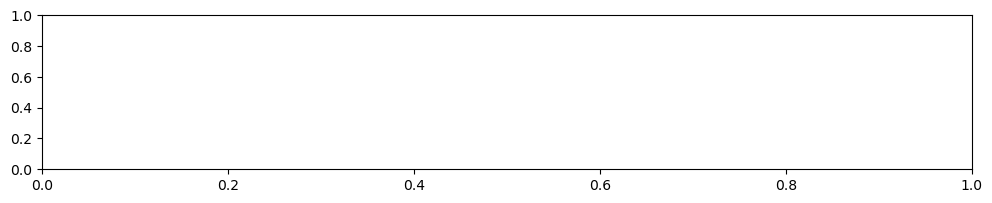

In [528]:
def interp_U(ds, z_loc, method = 'interp'):
                
    ffrac = np.isfinite(ds.u).sum(dim='time') / len(ds.time)
    
    thresh = 0.95
    
    if str(method) == 'interp':

        # find nearest velocity above / below:
        z_abv = ds.depth.values[(ds.depth.values > z_loc)&(ffrac.values>thresh)][0]
        z_blw = ds.depth.values[(ds.depth.values < z_loc)&(ffrac.values>thresh)][-1]
        print(f'       interp U({z_loc}) from: [{z_abv} {z_blw}]')

        U_abv = ds.se.sel(depth = z_abv).values
        U_blw = ds.se.sel(depth = z_blw).values

        # interp
        dz = z_loc-z_blw
        dZ = z_abv-z_blw
        dU = U_abv-U_blw
        U_interp = U_blw + dz*(dU/dZ)
        
    elif str(method) == 'nearest':
        
        # find nearest velocity above / below:
        z_retain = ds.depth.values[(ffrac.values>thresh)]
        z_near = z_retain[np.argmin(abs(z_retain - z_loc))]
        U_interp = ds.se.sel(depth = z_near).values
        print(f'       interp U({z_loc}) from: [{z_near}]')

    return U_interp
            
            
depths = [0, -16]#, -22, -28]

fig, ax = plt.subplots(figsize=(12,2))

OHT = np.array([])

for ii in range(len(depths[:-1])):
    
    z = {}
    Up = {}
    dT = {}
    
    z['a'] = depths[ii]
    z['b'] = depths[ii+1]
    
    dz = np.abs(z['a'] - z['b']) * units('m')
    
    print(f"layer {ii} [{z['a']}, {z['b']}], dz = {dz}")
    
    if z['a']==0:
#         dT['a'] = (0 + np.zeros(len(ds2.time))) * units('delta_degC')
        dT['a'] = (ds2.dT).sel(depth=z['b']).values * units('delta_degC')
        Up['a'] = ds3.se.values * units('m/s')
        rho_a = (ds2.sel(depth = z['b']).sig0 + 1000).values * units('kg/m^3')
        
    else:
        dT['a'] = (ds2.Ct - ds2.Tf).sel(depth=z['a']).values * units('delta_degC')
        Up['a'] = interp_U(ds, z['a'], method = 'nearest') * units('m/s')
        rho_a = (ds2.sel(depth = z['a']).sig0 + 1000).values * units('kg/m^3')
        
    dT['b'] = (ds2.Ct - ds2.Tf).sel(depth=z['b']).values * units('delta_degC')
    Up['b'] = interp_U(ds, z['b'], method = 'nearest') * units('m/s')
    rho_b = (ds2.sel(depth = z['b']).sig0 + 1000).values * units('kg/m^3')
    
    
    a_OHT = cst['Cp_o'] * rho_a * dT['a'] * Up['a']
    b_OHT = cst['Cp_o'] * rho_b * dT['b'] * Up['b']
    
    # add in the time component (hourly velocity measurements, so mass flux integrated over an hour)
#     a_OHT = a_OHT * units('hour').to('s')
#     b_OHT = b_OHT * units('hour').to('s')
    
    trap_OHT = 0.5 * (a_OHT + b_OHT) * dz
    
#     ax.plot(ds2.time, a_OHT)
#     ax.plot(ds2.time, b_OHT)
    
    ax.plot(ds2.time, trap_OHT/dz)

    

<IPython.core.display.Javascript object>


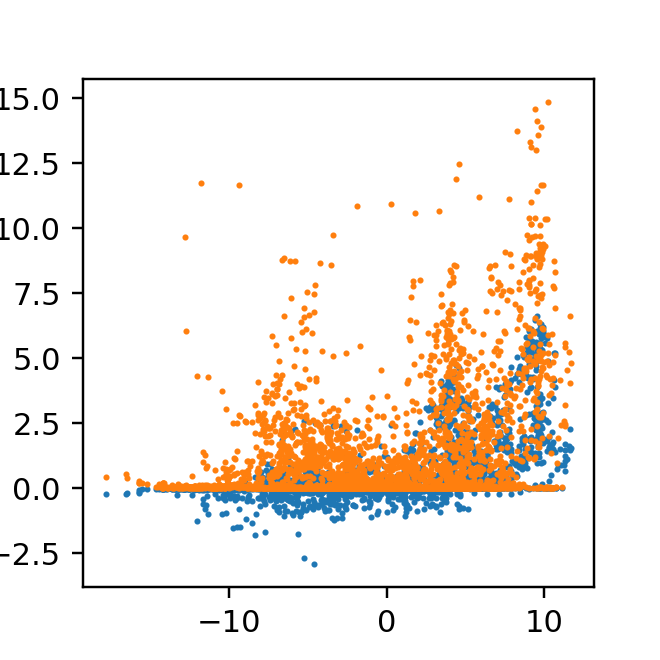

In [342]:
fig, ax = plt.subplots(figsize=(3,3))

lag = 6

ax.scatter(ds4.se[:-lag], ((trap_OHT/dz).to('W/m2')/(10**6))[lag:], s=1)

ax.scatter(ds4.se[:-lag], (THF/(10**2))[lag:], s=1)

In [534]:
daily_THF = np.array([])
for date in pd.to_datetime(DS.time.values):
    
    dt = (pd.to_datetime(ds.time.values)-date).total_seconds()/(3600)
    
    daily_THF = np.append(daily_THF, np.nanmean(THF[(dt >= 0)&(dt < 24)]))

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/num

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/3340587032.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya Extent\n($\mathrm{km^2}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/3340587032.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Turbulent\nOcean-Ice\nHeat Flux\n($\mathrm{\;W\;m^2}$)')


<IPython.core.display.Javascript object>


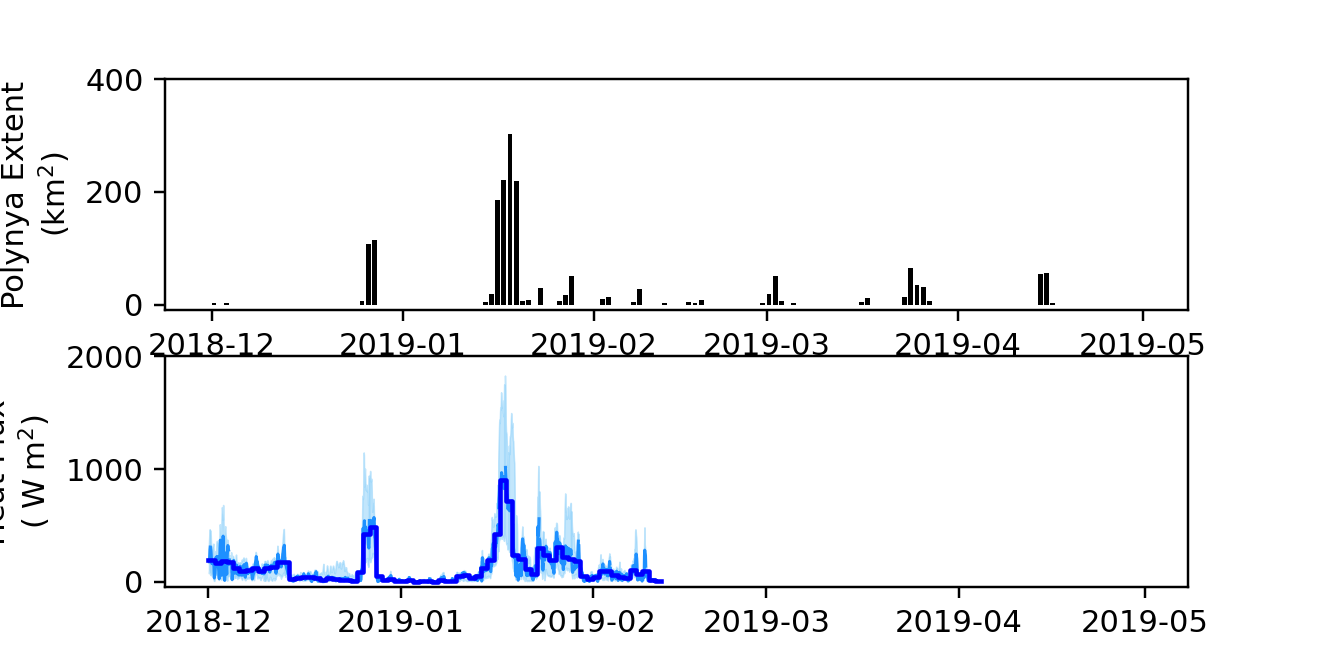

In [540]:
%matplotlib notebook

fig, axs = plt.subplots(2, 1, figsize=(6,3))

ax = axs[0]
ax.set_ylim(-10,400)
ax.bar(DS.time, DS.extent/20, align='edge', color='k')
ax.set_ylabel('Polynya Extent\n($\mathrm{km^2}$)')
# ax.bar(DS.time, DS.length, align='edge', color='gray')

ax = axs[1]
ax.set_ylim(-0.5*100,2000)
# ax2.plot(ds.time, (trap_OHT/dz).to('W/m2')/(10**4), lw=1, c='k')
# ax2.set_ylabel('Horizontal\nheat transport\n($10^3\mathrm{\;W\;m^2}$)')
# ax2.plot(ds.time, ds4.se/10, c='gray')

ax.fill_between(ds.time, THF_min, THF_max, color='lightskyblue', lw=0.5, alpha=0.5)
ax.plot(ds.time, THF, lw=1, c='dodgerblue')
ax.step(DS.time, daily_THF, color='b', where='post', zorder=2)

# ax2=ax.twinx()
# ax2.step(ds.time, ds2.dT.sel(depth=-16), color='r', zorder=2)


ax.set_ylabel('Turbulent\nOcean-Ice\nHeat Flux\n($\mathrm{\;W\;m^2}$)')
# THF

ax.set_xlim(datetime(2018,12,1)-timedelta(days=7), datetime(2019,5,1)+timedelta(days=7))

    
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


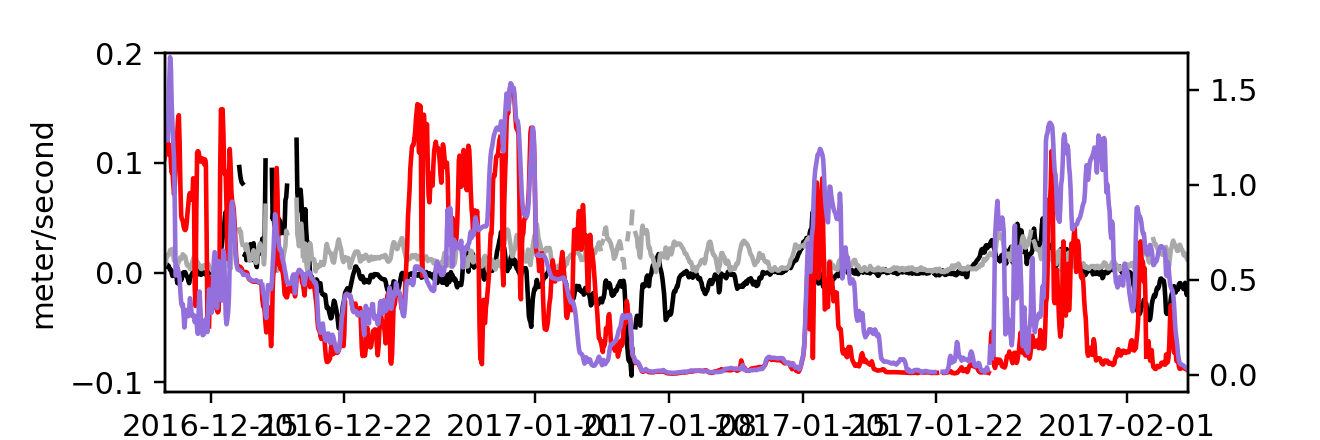

In [403]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(6,2))
# ax.set_ylim(-100,400)

ax.plot(ds3.time, ds3.se/10, color='k')
# ax.plot(ds3.time, ds.se.mean(dim='depth'), color='gray')

ax.plot(ds3.time, us, color='darkgray')

ax2 = ax.twinx()
ax2.plot(ds2.time, ds2.dT.sel(depth=-16), color='r')
ax2.plot(ds2.time, ds2.dT.sel(depth=-22), color='mediumpurple')
# ax.set_ylabel('Polynya Extent\n($\mathrm{km^2}$)')
# ax.bar(DS.time, DS.length, align='edge', color='gray')

## Calculate Integrate Ocean Heat Content

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [316]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -39.0 meter; dz = 11.0 meter


## Calculate Integrated Ocean Heat Transport

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; U_{\perp}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [497]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -36.0 meter; dz = 8.0 meter


In [498]:
# times = pd.to_datetime(ds2.time.values)
# times = np.append(times, times[-1] + timedelta(hours=1))

times = pd.to_datetime(ds2.time.values).to_pydatetime()
times = np.append(times, times[-1] + timedelta(hours=1))

time_grid, Zgrid = np.meshgrid(times, Z)#[:-1]+np.diff(Z)/2)

<IPython.core.display.Javascript object>


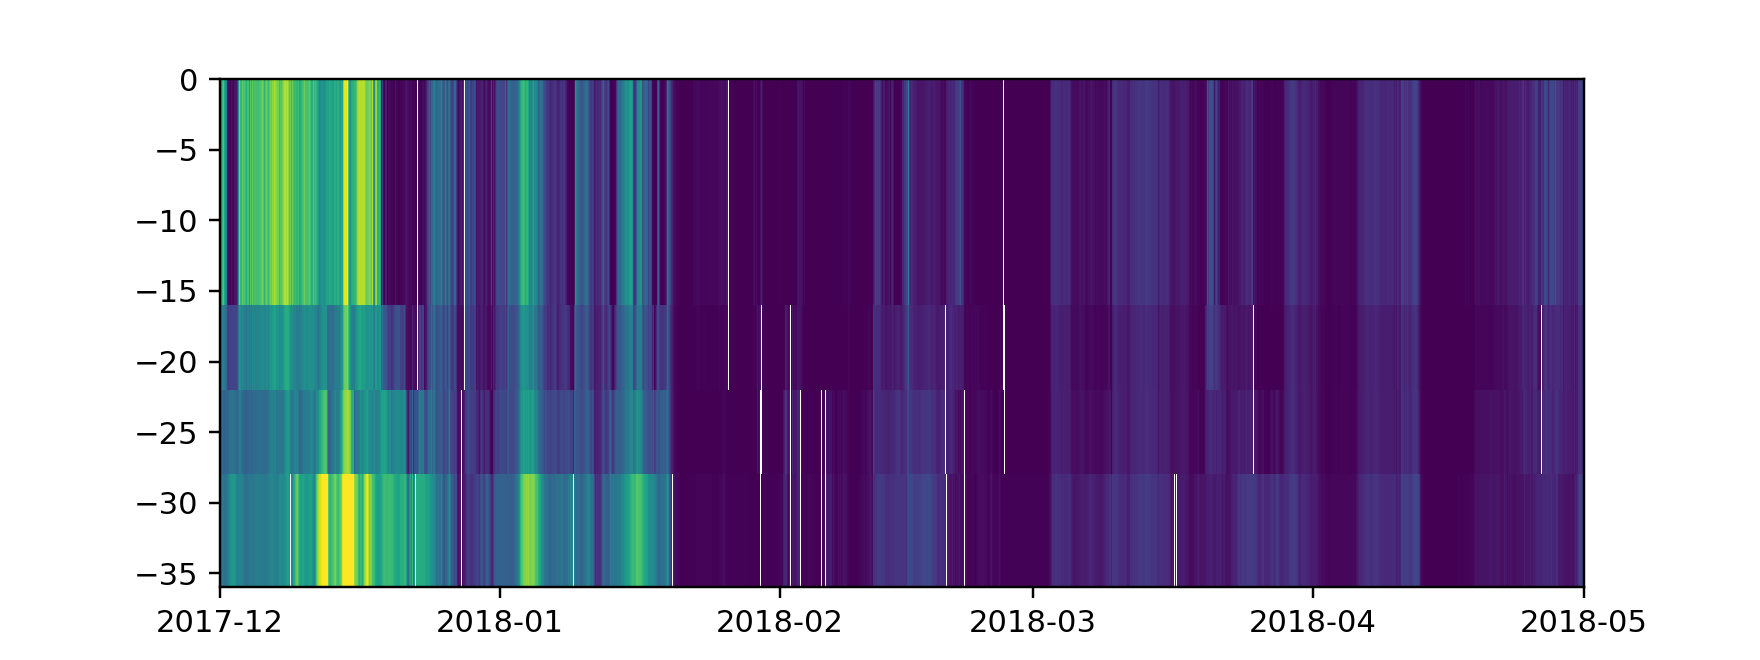

In [499]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh(time_grid, Zgrid, OHC, vmin=500000, vmax = 50000000)

<IPython.core.display.Javascript object>


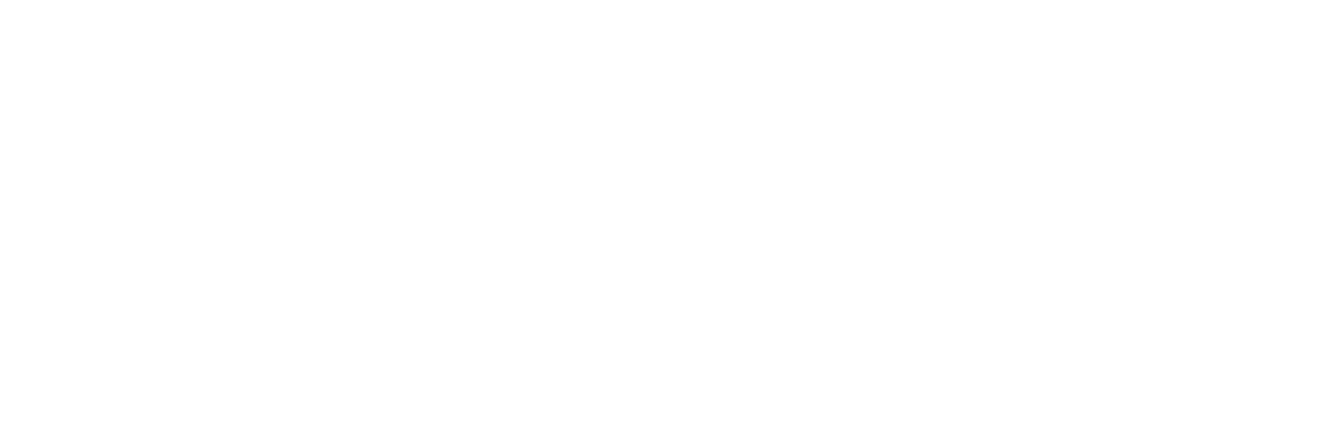

<IPython.core.display.Javascript object>


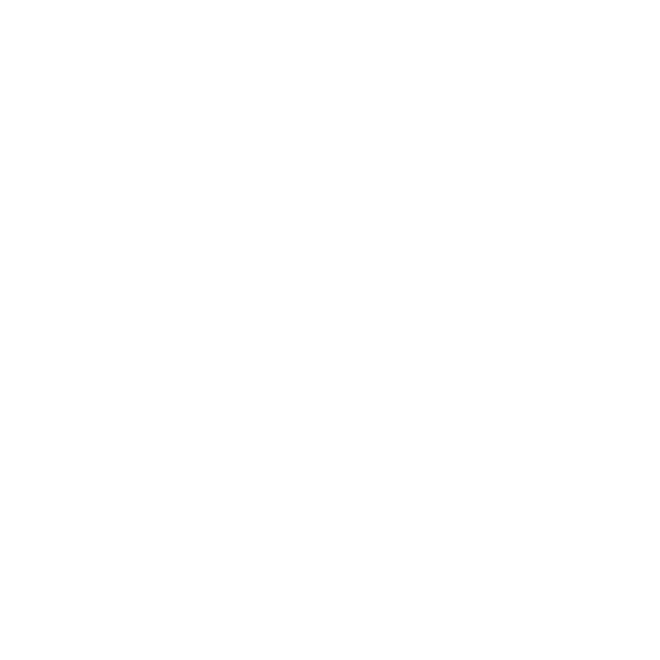

<IPython.core.display.Javascript object>


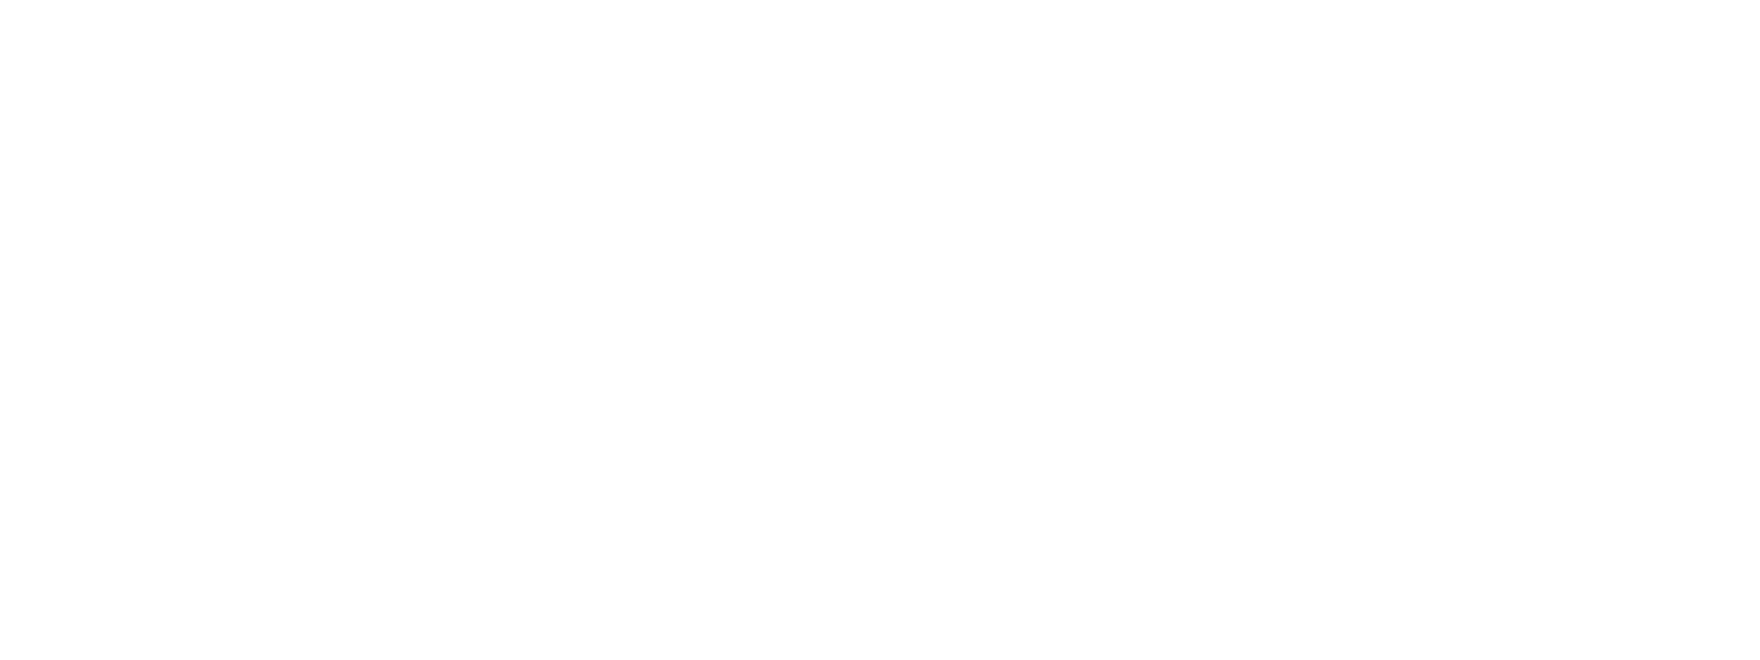

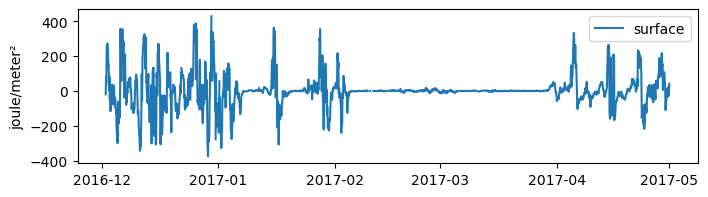

In [320]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,2))
# ax.set_ylim(-5000000,150000000)
# plt.plot(ds2.time, np.sum(OHC, axis=0), label = 'total')
# plt.plot(ds2.time, OHC[0,:], label = 'surface')

lag = 24

plt.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(24*60*60), label = 'surface')
plt.legend()

# ax.set_xlim(datetime(2017,12,1), datetime(2018,2,1))

<IPython.core.display.Javascript object>


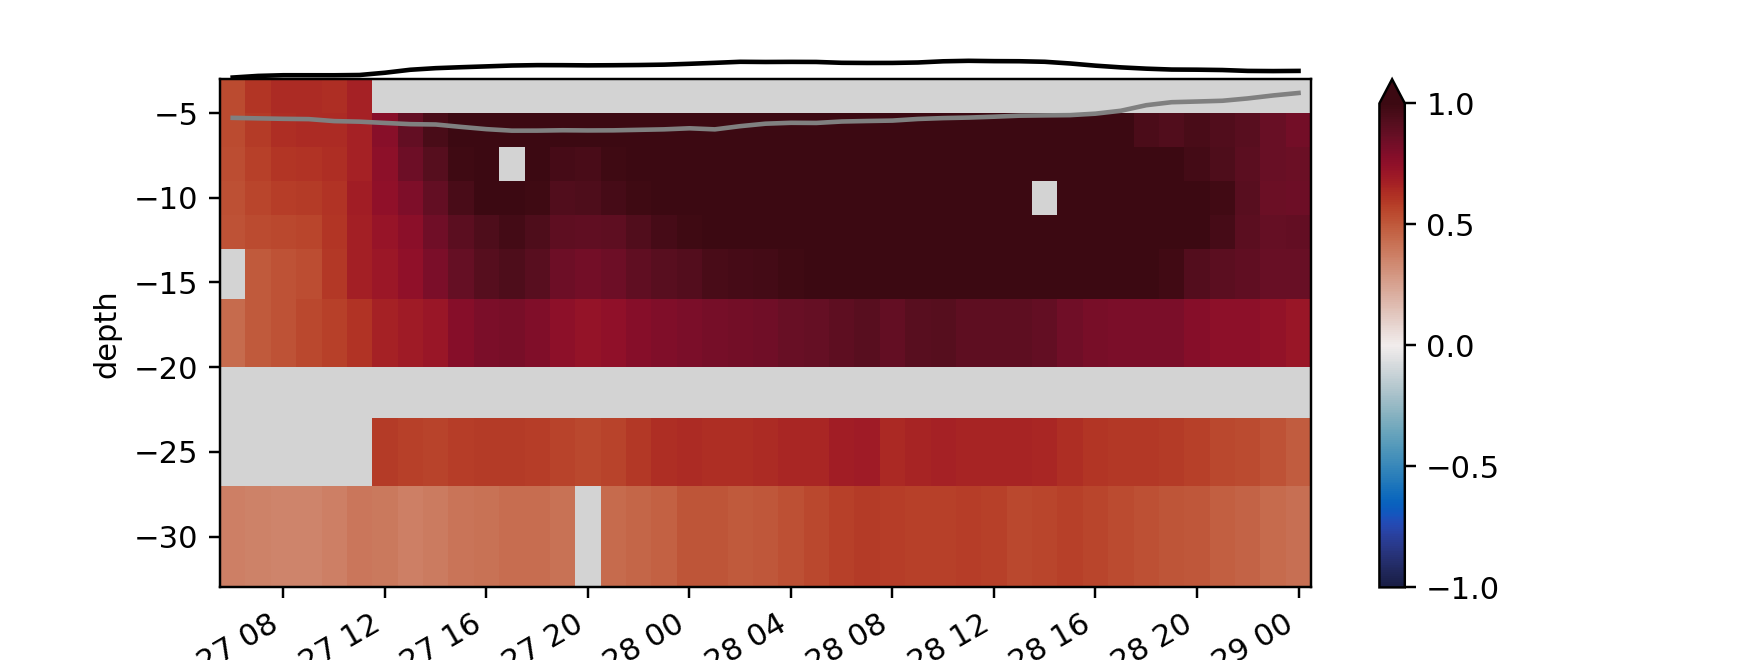

In [1453]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')

# event_time = slice(datetime(2016,12,15), datetime(2016,12,17, 12))

# event_time = slice(datetime(2016,12,15,12), datetime(2016,12,16, 16))

# event_time = slice(datetime(2018,1,13,0), datetime(2018,1,15,12 ))


event_time = slice(datetime(2019,1,27,6), datetime(2019,1,29, ))


along_sfc.sel(time=event_time).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

ax.plot(ds3.time.sel(time=event_time), ds3.se.sel(time=event_time)-3.5, c='k', clip_on=False)


ax.plot(ds3.time.sel(time=event_time), 0.2*ds4.u10.sel(time=event_time)-3.5, c='gray', clip_on=False)


In [1454]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

M1 = {}
M1['lon'] = np.array([ds3.attrs['lon']])
M1['lat'] = np.array([ds3.attrs['lat']])
M1['xx'], M1['yy'] = map_proj.transform_point(M1['lon'], M1['lat'], ccrs.PlateCarree())


print(M1)

{'lon': array([-139.2582]), 'lat': array([69.7718]), 'xx': 29546.27257084566, 'yy': -2281992.6265499666}


In [1455]:
import pyproj

def conv(projection, lon, lat, eastward = 1*units('m/s'), northward = 1*units('m/s')):

    """
    INPUT:
    - projection: projection to get final vector coordinates in 
    - eastward: eastward velocity component (with units)
    - northward: northward velocity component (with units)
    - lon: starting lon of vector (tail)
    - lat: starting lat of vector (tail)
    """
    
    # find vector speed and angle
    # theta defined CCW from eastward
    theta = vectors.vector_angle(eastward, northward)
    S = np.sqrt(eastward**2 + northward**2)
    
    # Define the bearing (in degrees) and the distance to travel (in meters)
    # bearing defined CW form northward
    #==================
    bearing = - (theta - 90 * units('degree'))
    distance = S.to('m/day') * units('day')    # m traveled in a day
    #==================
    
    geod = pyproj.Geod(ellps='WGS84') # Create a Geod object
    
    # find ending lon, lat of vector (m traveled over a day)
    vlon, vlat, _ = geod.fwd(lon, lat, bearing, distance)
    
    # find coordinates of vector end point (tip)
    tipx_proj, tipy_proj = projection.transform_point(vlon, vlat, ccrs.PlateCarree())

    # find coordinates of vector start point (tail)
    tailx_proj, taily_proj = projection.transform_point(lon, lat, ccrs.PlateCarree())

    # find vector difference between start and end points
    # this assumes coordinates of projection are units
    u = np.array([tipx_proj - tailx_proj]) * units('m')
    v = np.array([tipy_proj - taily_proj]) * units('m')
    
    tail = (tailx_proj, taily_proj)
    tip = (tipx_proj, tipy_proj)
    vec = (u,v)
    
    return tail, tip, vec





<IPython.core.display.Javascript object>


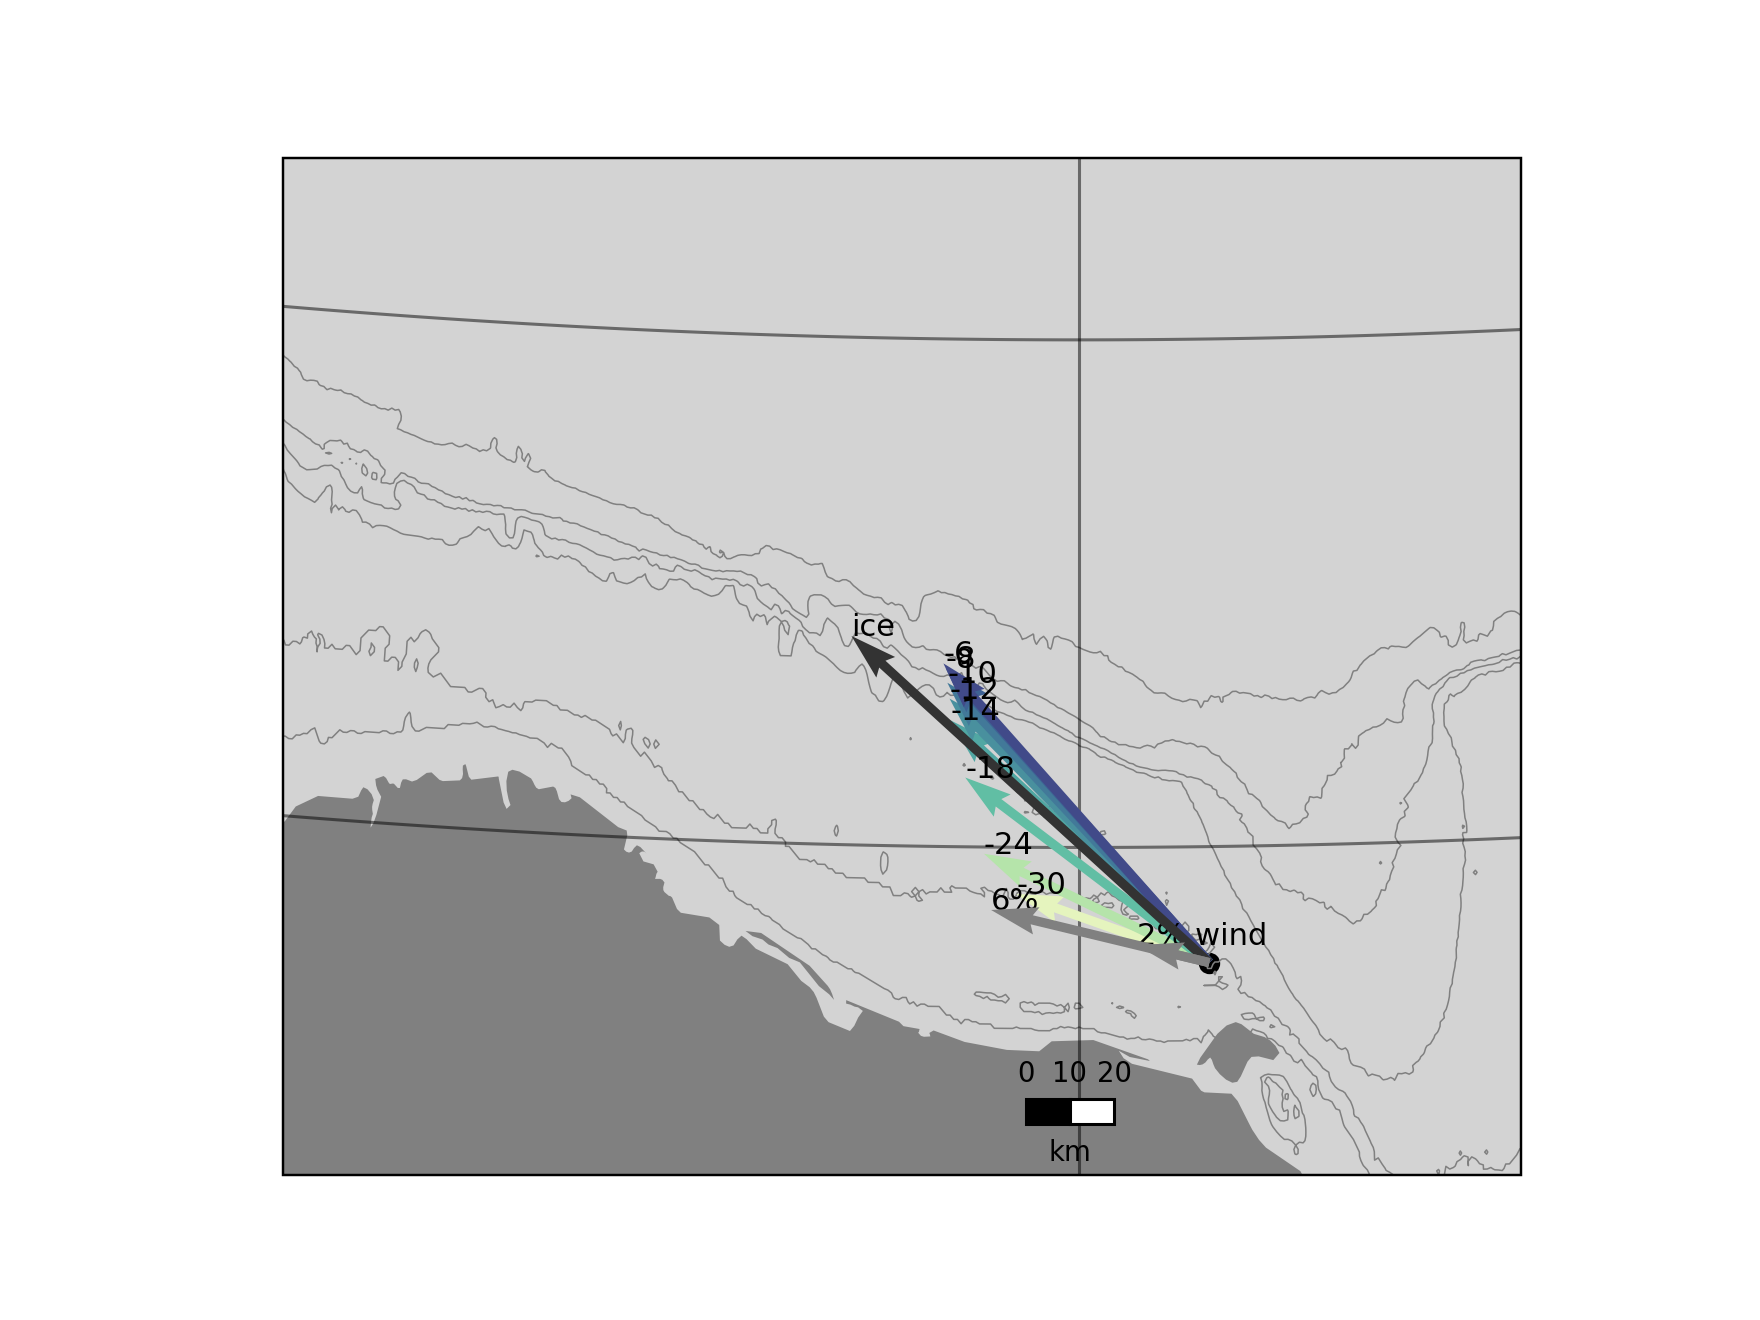

In [1456]:

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_xlim(-180000,100000)
ax.set_ylim(-2330000,-2100000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='gray', alpha=1, fill_dateline_gap = True, zorder=2)
geomap.grid(ax, lats = np.arange(69,75,1), lons = np.arange(200,250,5) , color='k')

geomap.scalebar(ax, loc=(0.6, 0.05), stepsize=10, numsteps=2, unit='km', label=None, 
                colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
                labelpad=0.015, ticklabelpad=0.01, zorder=100)

ax.scatter(*tail, c='k')


label_side = 'left'

geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
                        crop_lat=(69, 71), crop_lon=(-147, -135), clat=2, clon=5, 
                        contour_labels=False,
                        contour_levels=[-500,-300,-200,-100,  -40,-20],
                        contour_kwargs={'colors': 'gray', 'linewidths': 0.5, 'linestyles': 'solid', 'zorder': 1},
                        depth_shade=False)


# wind
U = 0.06 * np.array([ds4.u10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = 0.06 * np.array([ds4.v10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
ax.quiver(*tail, *vec, color='gray', pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=4)
ax.text(*tip, '6%', ha=label_side, color='k',)

U = 0.02 * np.array([ds4.u10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = 0.02 * np.array([ds4.v10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
ax.quiver(*tail, *vec, color='gray', pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=4)
ax.text(*tip, '2% wind', ha=label_side, color='k',)

# ice drift 
Ui = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
Vi = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = Ui, northward = Vi)
ax.quiver(*tail, *vec, color=[0.2,0.2,0.2], pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=3)
ax.text(*tip, 'ice', ha=label_side, color='k',)

# ocean currents
color_list = cmocean.cm.deep(np.linspace(0.05,0.85,len(ds.depth.values)))
for dd, depth in enumerate(ds.depth.values):
    
    color = color_list[dd]
    ffrac = np.sum(np.isfinite(ds.u.sel(depth = depth, time=event_time))).values / len(ds.time.sel(time=event_time).values)
    
    if ffrac > 0.5:

        
        U = np.array([ds.u.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        V = np.array([ds.v.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')

        tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
        ax.quiver(*tail, *vec, color=color, pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=2)
        ax.text(*tip, f'{depth:.0f}', ha=label_side, color='k',)



<IPython.core.display.Javascript object>


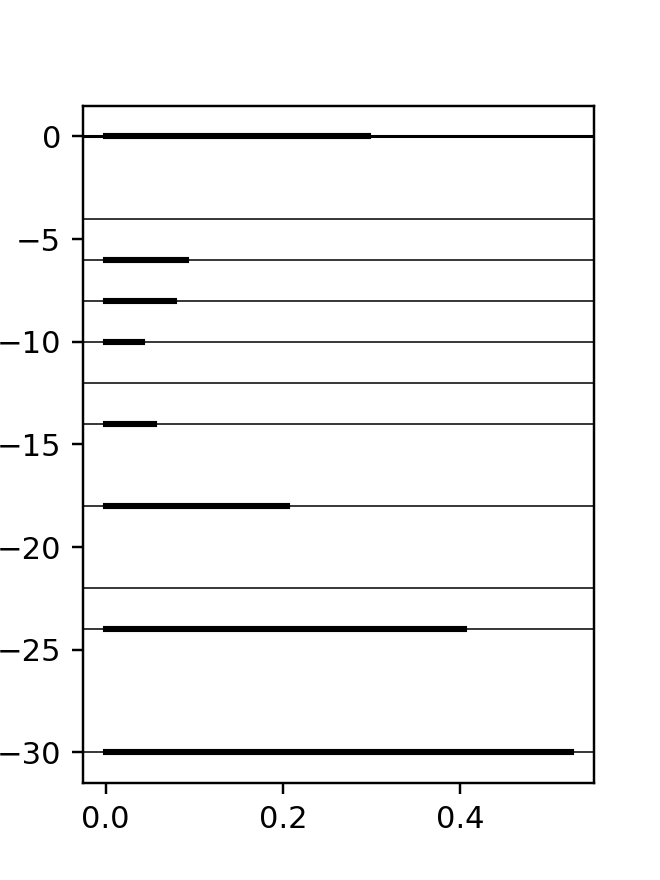

In [1481]:
# ice drift 
# Ui = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# Vi = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')

Ui = np.array([ds.u.sel(depth=-12).sel(time=event_time).mean(dim='time').values]) * units('m/s')
Vi = np.array([ds.v.sel(depth=-12).sel(time=event_time).mean(dim='time').values]) * units('m/s')

fig, ax = plt.subplots(figsize=(3,4))
ax.axhline(0, lw=1, c='k', zorder=0)
# ax.set_xlim(-0.1,1)
# ocean currents
color_list = cmocean.cm.deep(np.linspace(0.05,0.85,len(ds.depth.values)))
for dd, depth in enumerate(ds.depth.values):
    
    ax.axhline(depth, lw=0.5, c='k', zorder=0)
    color = color_list[dd]
    ffrac = np.sum(np.isfinite(ds.u.sel(depth = depth, time=event_time))).values / len(ds.time.sel(time=event_time).values)
    
    if ffrac > 0.5:

        U = np.array([ds.u.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        V = np.array([ds.v.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        
        vec_diff = np.sqrt((Ui-U)**2 + (Vi-V)**2).magnitude[0]
        
        ax.plot([0,vec_diff], [depth,depth], c='k', lw=2)

        
U = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')

vec_diff = np.sqrt((Ui-U)**2 + (Vi-V)**2).magnitude[0]
depth=0
ax.plot([0,vec_diff], [depth,depth], c='k', lw=2)




<IPython.core.display.Javascript object>


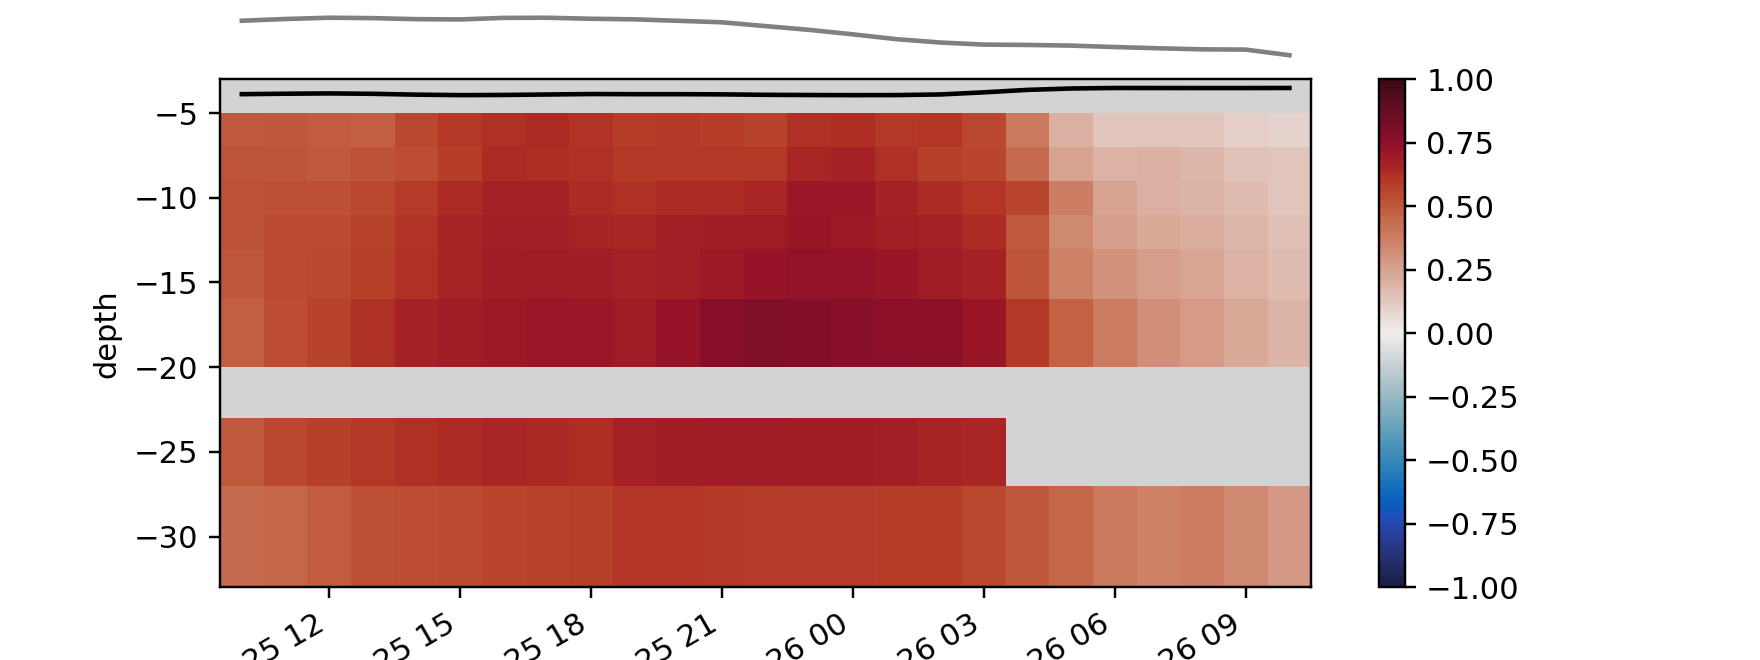

In [1680]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')

# event_time = slice(datetime(2016,12,15), datetime(2016,12,17, 12))

# event_time = slice(datetime(2016,12,15,12), datetime(2016,12,16, 16))

# event_time = slice(datetime(2018,1,13,0), datetime(2018,1,15,12 ))


# event_time = slice(datetime(2019,1,27,6), datetime(2019,1,29, ))

# event_time = slice(datetime(2019,1,28,6), datetime(2019,1,29, ))
# event_time = slice(datetime(2019,1,27), datetime(2019,1,31, ))
event_time = slice(datetime(2018,2,25,10), datetime(2018,2,26, 10))

along_sfc.sel(time=event_time).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

ax.plot(ds3.time.sel(time=event_time), ds3.se.sel(time=event_time)-3.5, c='k', clip_on=False)


ax.plot(ds3.time.sel(time=event_time), 0.2*ds4.u10.sel(time=event_time)-3.5, c='gray', clip_on=False)


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<IPython.core.display.Javascript object>


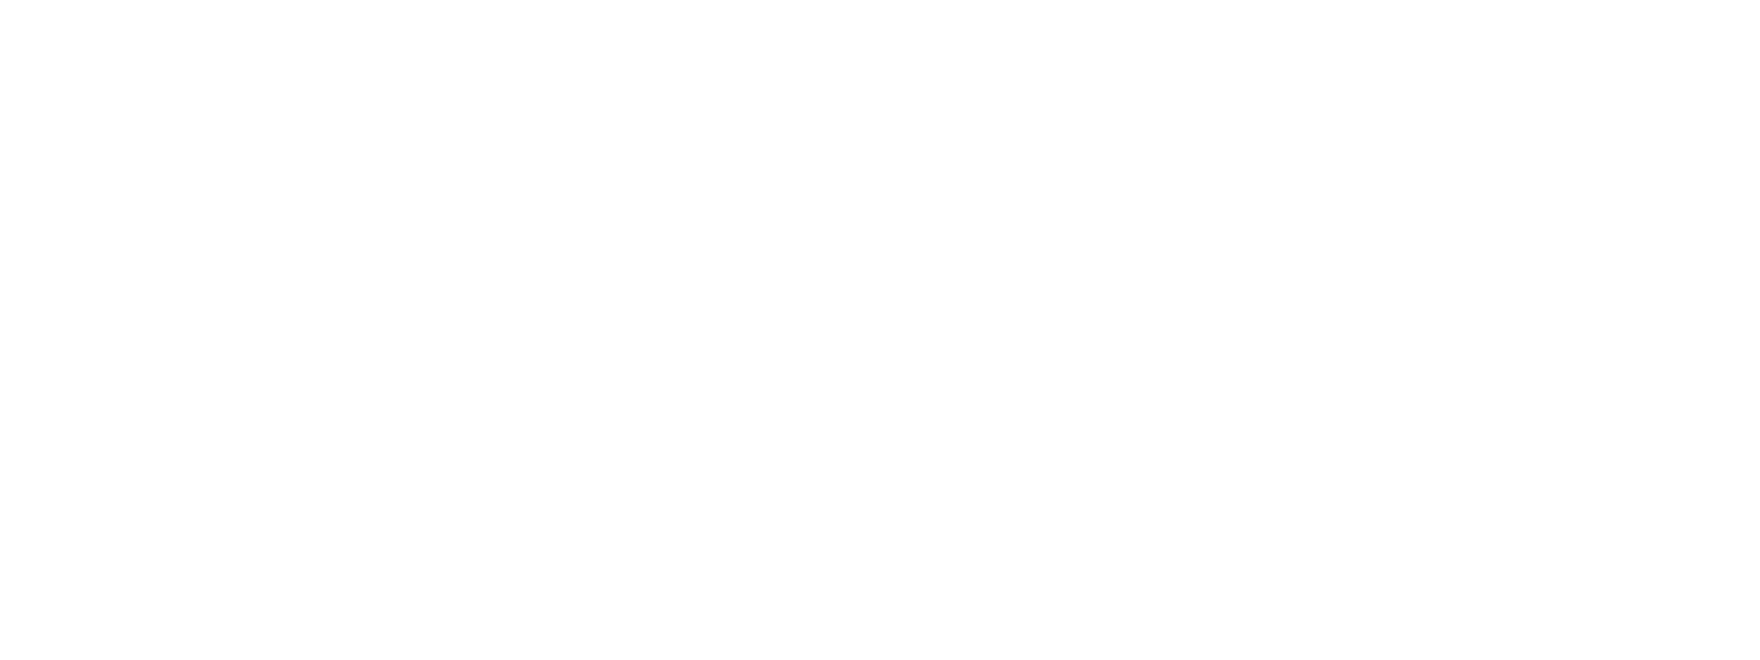

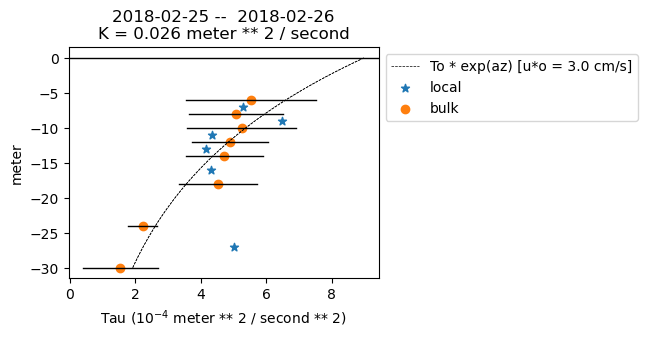

In [1681]:
%matplotlib inline

def simple_exp_tau(z, K = 0.026 * units('m2/s'), lat = 70, To = 10*10**(-4) * units('m2/s2')):
    
    # coriolis frequency
    om = 7.2921 * 10 **(-5)
    f = 2 * om * np.sin(lat*np.pi/180) * units('s')**(-1)
    a = np.sqrt(0.5*f/K)
    T = To * np.exp(a * z)
    
    return T

    




scale = 10**(-4)
fig, ax = plt.subplots(figsize=(4,3))
ax.axhline(0, lw=1, c='k', zorder=0)

z = np.linspace(-30,0,100) * units('m')


K = 0.026 * units('m2/s')


Uos = np.array([0.03]) * units('m/s')
Tos = Uos**2

for To in Tos:
    T = simple_exp_tau(z, To = To, K = K)
    plt.plot(T/scale, z, ls = 'dashed', c='k', lw=0.5)
    
uslabel = (Uos[0].to('cm/s')).magnitude
plt.plot(T/scale, z, ls = 'dashed', c='k', lw=0.5, label=f'To * exp(az) [u*o = {uslabel:.1f} cm/s]')

Ui = ds3.u
Vi = ds3.v

urel = (ds.u - Ui) 
vrel = (ds.v - Vi)

dudz_x = (urel / ds.depth ) * (1/units('s'))
dudz_y = (vrel / ds.depth ) * (1/units('s'))
dudz = np.sqrt(dudz_x**2+dudz_y**2)
# zmid = (ds.depth[:-1].values + ds.depth.diff('depth').values/2) * units('m')


z = ds.depth.values * units('m')
event_shear = dudz.sel(time=event_time).mean(dim='time').values * (1/units('s'))
event_shear_std = dudz.sel(time=event_time).std(dim='time').values * (1/units('s'))



dudz_x = ds.u.diff('depth') / ds.depth.diff('depth')
dudz_y = ds.v.diff('depth') / ds.depth.diff('depth')
dudz = np.sqrt(dudz_x**2+dudz_y**2)

shear_local = dudz.sel(time=event_time).mean(dim='time').values

top_z = ds.depth[-1]
top_shear = np.sqrt((urel.sel(depth=top_z)/ (top_z))**2+(vrel.sel(depth=top_z)/ (top_z))**2)
shear_local = np.append(shear_local, top_shear.sel(time=event_time).mean(dim='time'))
shear_local = shear_local * (1/units('s'))

TL = (shear_local * K)
zmid = (ds.depth[:-1].values + ds.depth.diff('depth').values/2) 
zmid = np.append(zmid, top_z/2)
zmid = zmid * units('m')
plt.scatter(TL/scale, zmid, marker='*', label='local', zorder=2)

T2 = (event_shear * K)
T2min = ((event_shear - event_shear_std) * K)
T2max = ((event_shear + event_shear_std) * K)

plt.scatter(T2/scale, z, label='bulk', zorder=1)

for min_, max_, z_ in zip(T2min.magnitude, T2max.magnitude, z.magnitude):
    plt.plot([min_/scale, max_/scale], [z_,z_], c='k', lw=1)
    
    

# ax.set_xlim(-0.0001/scale,0.002/scale) 
plt.xlabel('Tau ($10^{-4}$'+f' {T2.units})')
plt.legend(bbox_to_anchor=(1,1))



ax.set_title(f'{event_time.start.date()} --  {event_time.stop.date()}\nK = {K}')

fig.savefig(f'./figures/stress/stress_profile_{event_time.start.date()}_{event_time.stop.date()}.png', dpi=300, bbox_inches = 'tight', pad_inches=0)

In [1709]:

import cmath

In [2134]:
def create_V(depth, date):

    # ocean vector (in cm/s)
    uo = (ds.u.sel(depth=depth).sel(time=date).data * units('m/s').to('cm/s')).magnitude
    vo = (ds.v.sel(depth=depth).sel(time=date).data * units('m/s').to('cm/s')).magnitude
    Uo = complex(uo, vo)
    
    # ice vector (in cm/s)
    ui = (ds3.u.sel(time=date).data * units('m/s').to('cm/s')).magnitude
    vi = (ds3.v.sel(time=date).data * units('m/s').to('cm/s')).magnitude
    Ui = complex(ui, vi)
    
    # ice velocity with ocean removed
    V = Ui - Uo
    # Get polar coordinates
    # r, phi = cmath.polar(V)

    return Uo, Ui, V

In [2135]:


def newton_iter(xn, V, k = 0.4, A = 2.3, B = 2.1, lat = 70, z0 = 5 * units('cm')):
    
    # coriolis frequency
    om = 7.2921 * 10 **(-5)
    f = 2 * om * np.sin(lat*np.pi/180) * units('s')**(-1)
    
    # surface friction rossby number
    unm = cmath.polar(xn)[0] * units('cm/s')
    
    
    unR = xn.real
    alpha = 1/(f*z0)
    c = complex(A, B)
    
    
    Fn = V - (1/k) * (np.log(alpha*unm) - c) * xn
    dFdun = - (1/k) * ((unR/unm.magnitude**2)*xn + np.log(alpha*unm) - c)
    
    xnp1 = xn - Fn/dFdun
    
    return xnp1, Fn


In [2155]:
starttime = datetime.now()

dates = pd.date_range(datetime(2017,12,1), datetime(2018,4,30), freq = '6H')

us0 = {}
z0_vals = [0.001, 0.05] # in units of m
depths = [-30,-12,-6]

for z0 in z0_vals:
    us0[z0] = {}
    for depth in depths:
        us0[z0][depth] = np.array([])
    

for date in dates:
    
    for z0 in z0_vals:
    
        for depth in depths:
            
            all_us = np.array([])

            # relaive ice-ocean velocities
            Uo, Ui, V = create_V(depth, date)

            # initial guess
            x0 = 5 * cmath.exp(1j * np.pi/4)
            
            # newton iteration
            #-----------------
            guesses = [x0]
            tolerance = 0.001
            num_iter = 50

            for ii in range(num_iter):

                xn = guesses[-1]
                xnp1, Fn = newton_iter(xn, V, k = cst['kappa'], A = 2.3, B = 2, z0 = z0 * units('m'))
                guesses.append(xnp1)

                dx = xnp1 - xn
                if cmath.polar(dx)[0] < tolerance:
                    break

            if ii < num_iter-1:
                us0[z0][depth] = np.append(us0[z0][depth], guesses[-1])
            else:
                us0[z0][depth] = np.append(us0[z0][depth], np.nan)

                
# grab magnitudes
usm = {}
for z0 in z0_vals:
    usm[z0] = {}
    for depth in depths:
        usm[z0][depth] = np.array([])
        for us in us0[z0][depth]:
            usm[z0][depth] = np.append(usm[z0][depth], cmath.polar(us)[0])
            
print(f'>>>> runtime: {datetime.now() - starttime}')

>>>> runtime: 0:01:11.068019


<IPython.core.display.Javascript object>


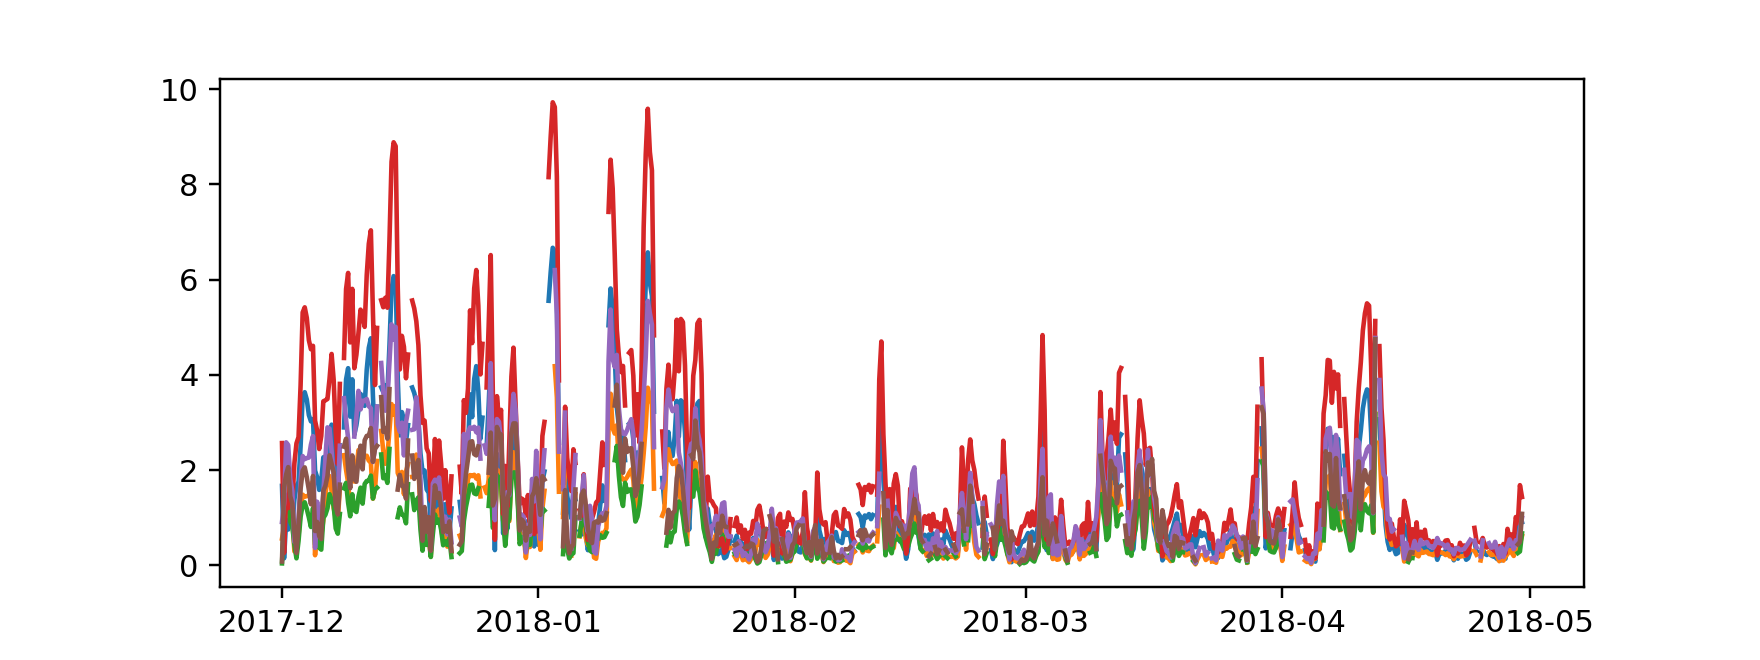

In [2158]:
fig, ax = plt.subplots(figsize=(8,3))
# plt.plot(dates, us['-12'])

for z0 in z0_vals:
    plt.plot(dates, usm[z0][-30])
    plt.plot(dates, usm[z0][-12])
    plt.plot(dates, usm[z0][-6])


In [2160]:
depth

-6

<IPython.core.display.Javascript object>


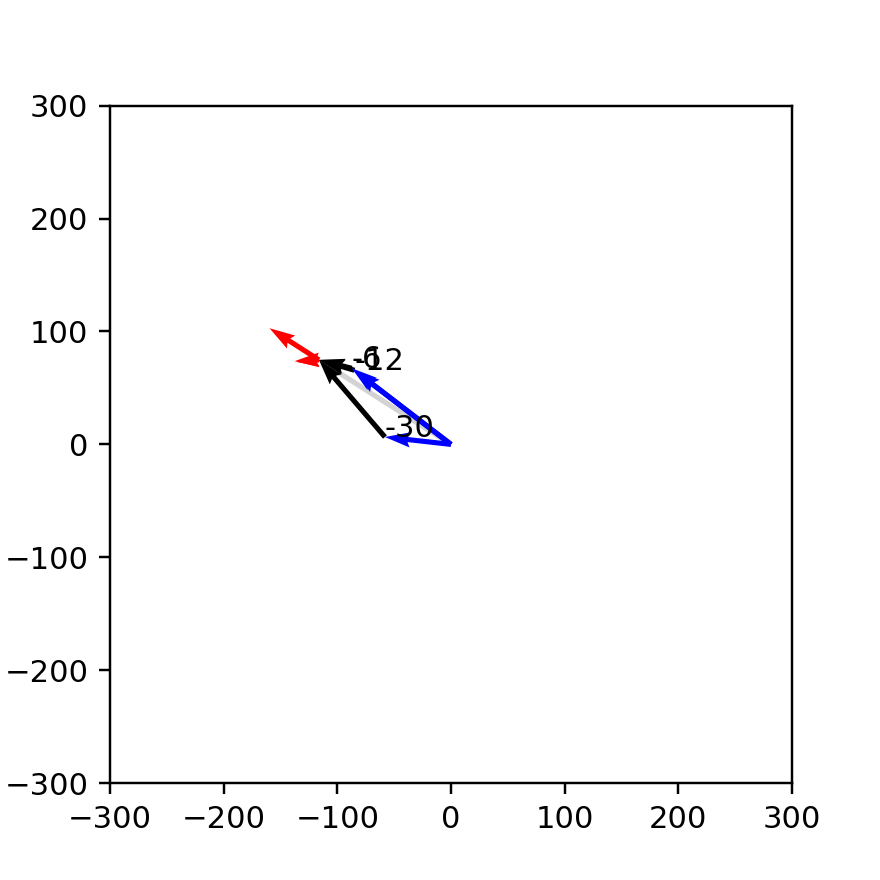

-159.66093844051068  102.86218277968763  -30
-137.53659492792661  73.73702947640463  -12
-135.9227278739465  73.06300295734566  -6


In [2198]:



fig, ax = plt.subplots(figsize=(4,4))
size=300
ax.set_xlim(-size,size)
ax.set_ylim(-size,size)
    


date = datetime(2018,1,18,6)
di = np.where(dates == date)[0][0]

Uo, Ui, V = create_V(depth, date)
plt.quiver(0, 0, Ui.real, Ui.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='lightgray')

# relaive ice-ocean velocities
for depth in depths:
    
    Uo, Ui, V = create_V(depth, date)
    ax.quiver(0, 0, Uo.real, Uo.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='b')
    ax.quiver(Uo.real, Uo.imag, V.real, V.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='k')
    ax.text(Uo.real, Uo.imag, depth, zorder=100)

    z0 = 0.05
    
    usx = 10*us0[z0][depth][di].real
    usy = 10*us0[z0][depth][di].imag
    
    ax.quiver(Ui.real, Ui.imag, usx, usy, angles='xy', scale_units='xy', scale=1, pivot='tail', color='r')
    print(Ui.real+usx, Ui.imag+usy, depth)
#     ax.text(Ui.real+usx, Ui.imag+usy, depth, zorder=100)
    
# plt.quiver(0, 0, x0.real, x0.imsag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='b')

# plt.quiver(Uo.real, Uo.imag, V.real, V.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='gray')


<IPython.core.display.Javascript object>


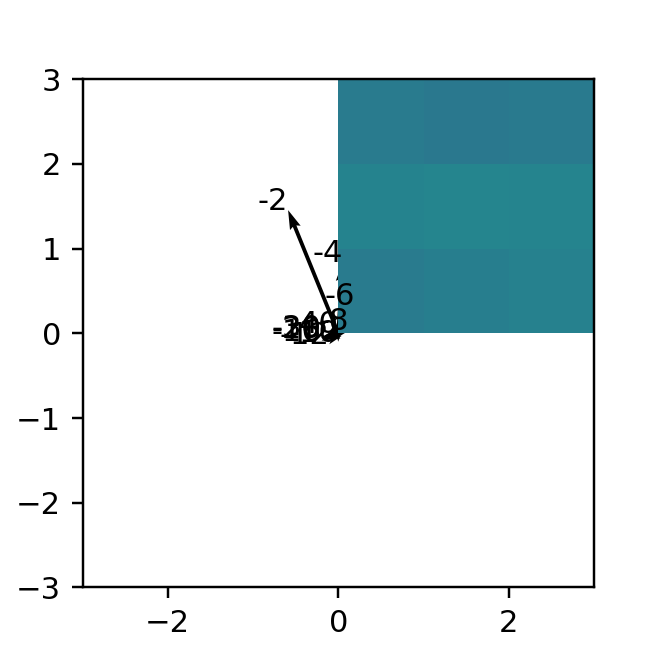

(-3.0, 3.0)

In [1336]:
#https://en.wikipedia.org/wiki/Ekman_spiral#cite_note-GFD-3

Av = 10 * units('cm')**2/units('s') # vertical turbulent viscosity coefficient
# Av = 500 * units('cm')**2/units('s') # vertical turbulent viscosity coefficient
# https://www.sciencedirect.com/science/article/pii/0278434394E0037M


# bottom boundary
# https://uhslc.soest.hawaii.edu/ocn620/notes_pdf/ekman.pdf
# Av: diffusivity, Av, which could be eddy or molecular

om = 7.2921 * 10 **(-5)
f = 2 * om * np.sin(70*np.pi/180) * units('s')**(-1)
dE = np.sqrt(2 * Av / f).to('m')
rho = cst['rho_o']

dE

# z = np.arange(-40, 0) * units('m')

z = np.array([-40,-30,-20,-16,-12,-10,-8,-6,-4,-2]) * units('m')

Tx = -1 * units('N/m2')
Ty = 0 * units('N/m2')
phi = (z/dE - np.pi/4)

slope = Tx.magnitude * units('m/s')


fig, ax = plt.subplots(figsize=(3,3)) 
u = ((dE/(rho*Av*np.sqrt(2)))* np.exp(z/dE) * (Tx*np.cos(phi) - Ty*np.sin(phi))).to_base_units()
v = ((dE/(rho*Av*np.sqrt(2)))* np.exp(z/dE) * (Tx*np.sin(phi) + Ty*np.cos(phi))).to_base_units()

# plt.plot(u, z)
# plt.plot(v, z)

# bottom
U = u[z < z[np.where(-z > 2*dE)[0]].max()][-1]
V = v[z < z[np.where(-z > 2*dE)[0]].max()][-1]
zb = z - z[0]
ut = - U * (1 - np.exp(-zb/dE) * np.cos(zb/dE)) - V * (np.exp(-zb/dE) * np.sin(zb/dE))
vt = U * np.exp(-zb/dE) * np.sin(zb/dE) + V * (1 - np.exp(-zb/dE) * np.cos(zb/dE))


# plt.plot(ut, z)
# plt.plot(vt, z)

total_u = ut + u 
total_v = vt + v

# plt.plot(total_u, z)
# plt.plot(total_v, z)


sp = 1
ax.quiver(np.zeros(len(z))[::sp], 
           np.zeros(len(z))[::sp],
           total_u[::sp], 
           total_v[::sp],  angles='xy', scale_units='xy', scale=1 )


label_side = 'right'
for u, v, t in zip(total_u[::sp],total_v[::sp],z[::sp].magnitude):
    ax.text(u.magnitude, v.magnitude, f'{t}', ha=label_side)
    

    

ax.set_xlim(-3,3)
ax.set_ylim(-3,3)


In [1373]:
depth = -10

U = along_sfc.sel(depth = depth, time=event_time).mean(dim='time').values
V = perp_sfc.sel(depth = depth, time=event_time).mean(dim='time').values

a = np.array([U,V])
b = np.array([1,0])
c = np.dot(a,b)/np.linalg.norm(a)/np.linalg.norm(b) # -> cosine of the angle
angle = np.arccos(np.clip(c, -1, 1)) # if you really want the angle

ocean_speed = np.sqrt(ds.u**2+ds.v**2).sel(depth = depth, time=event_time)
speed_ratio = np.nanmean(ocean_speed)/np.nanmean(icespeed.sel(time=event_time))

print(f'angle: {angle * 180/np.pi : .1f}')
print(f'speed ratio: {speed_ratio : .3f}')

angle:  0.3
speed ratio:  0.678


In [529]:
us0 = {}




def calc_CD(z, z0, kappa):
    
    # z is positive here
    sqrt_CD = ((1/kappa)*np.log(z/z0))**(-1)

    return sqrt_CD
    
    
z0_vals = [0.0001, 0.001, 0.05, 0.1]

z_vals = [-6,-8,-10,-12,-24,-30]
# z_vals = [-11.3, -15.3, -23.3]

for z0 in z0_vals:
    
    us0[z0] = {}
    
    print(f'\nz0 = {z0}')

    for z in z_vals:

        
        sqrt_CD = calc_CD(-z, z0, cst['kappa'])
        print(f'   z = {z}, sqrt_CD = {sqrt_CD:.3f}')
        
        del_u = ds.u.sel(depth = z) - u_sfc
        del_v = ds.v.sel(depth = z) - v_sfc
        dU = np.sqrt(del_u**2 + del_v**2)

        us0_val = sqrt_CD * dU.values
        
        us0[z0][z] = us0_val


z0 = 0.0001
   z = -6, sqrt_CD = 0.036 
   z = -8, sqrt_CD = 0.035 
   z = -10, sqrt_CD = 0.035 
   z = -12, sqrt_CD = 0.034 
   z = -24, sqrt_CD = 0.032 
   z = -30, sqrt_CD = 0.032 

z0 = 0.001
   z = -6, sqrt_CD = 0.046 
   z = -8, sqrt_CD = 0.045 
   z = -10, sqrt_CD = 0.043 
   z = -12, sqrt_CD = 0.043 
   z = -24, sqrt_CD = 0.040 
   z = -30, sqrt_CD = 0.039 

z0 = 0.05
   z = -6, sqrt_CD = 0.084 
   z = -8, sqrt_CD = 0.079 
   z = -10, sqrt_CD = 0.075 
   z = -12, sqrt_CD = 0.073 
   z = -24, sqrt_CD = 0.065 
   z = -30, sqrt_CD = 0.063 

z0 = 0.1
   z = -6, sqrt_CD = 0.098 
   z = -8, sqrt_CD = 0.091 
   z = -10, sqrt_CD = 0.087 
   z = -12, sqrt_CD = 0.084 
   z = -24, sqrt_CD = 0.073 
   z = -30, sqrt_CD = 0.070 


<IPython.core.display.Javascript object>


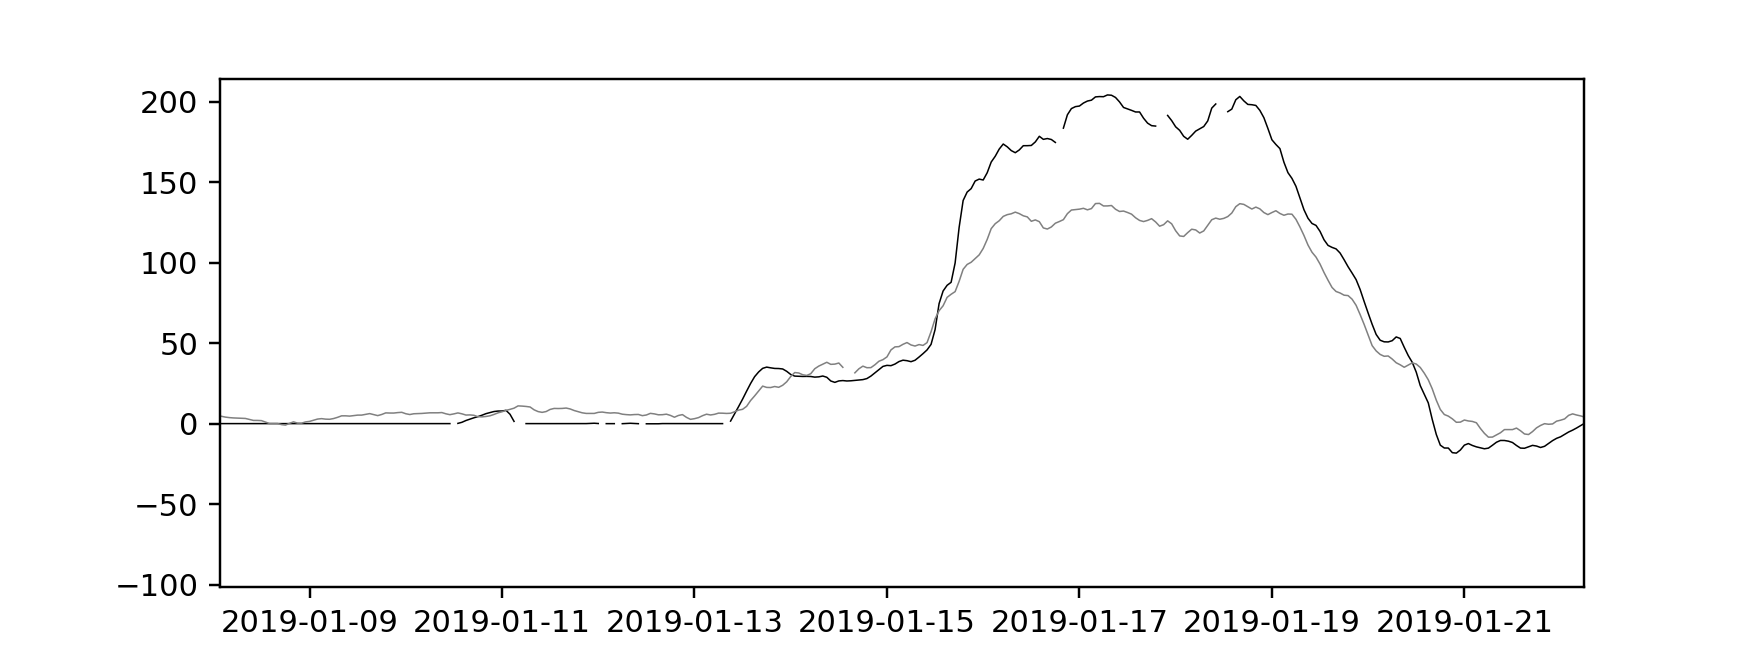

In [605]:
%matplotlib notebook

fig, ax= plt.subplots(figsize=(8,3))
plt.plot(ds3.time, ds3.se* units('m/s').to('km/day'), c='k', lw=0.5)
plt.plot(ds.time, ds.se.sel(depth=-10)* units('m/s').to('km/day'), c='gray', lw=0.5)

In [623]:
wind_angle

<Quantity([-165.65416   -166.94397   -168.34123   ...   14.4704       1.6910133
   -9.494447 ], 'degree')>

In [636]:


wind_angle = vectors.vector_angle(ds4.u10.values, ds4.v10.values)
wind_speed = np.sqrt(ds4.u10.values**2 + ds4.v10.values**2)

fd_ice_angle = wind_angle + 20 * units('degree')
fd_ice_speed = 0.02 * wind_speed

fd_ice_u = fd_ice_speed * np.cos(fd_ice_angle)
fd_ice_v = fd_ice_speed * np.sin(fd_ice_angle)
fd_ice_se = vectors.comp_along_theta(fd_ice_u, fd_ice_v, 135 * units('degree'))

# u_norm = u_sfc / icespeed
# v_norm = v_sfc / icespeed

# u_perp = - v_norm
# v_perp = u_norm

# along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
# perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))

<IPython.core.display.Javascript object>


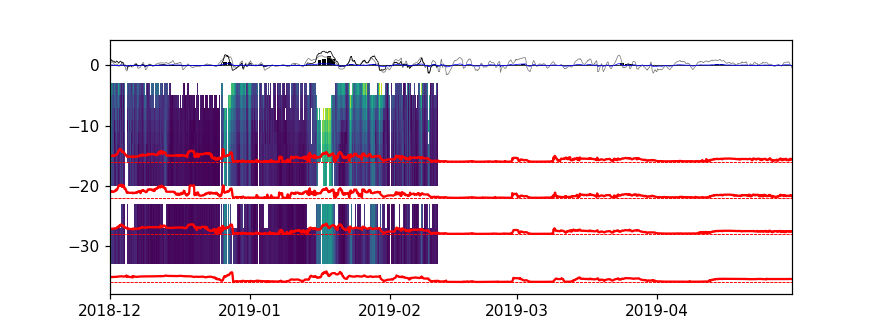

In [726]:
%matplotlib notebook

fig, ax= plt.subplots(figsize=(8,3))

# dudz = ds.u.diff('depth') / ds.depth.diff('depth')
# dvdz = ds.v.diff('depth') / ds.depth.diff('depth')
# shear = np.sqrt(dudz**2 + dvdz**2)

# plt.pcolormesh(ds.time, ds.depth.values[:-1], shear, vmin=0, vmax=0.1)

dudz = (ds3.u.values - ds.u) / ds.depth
dvdz = (ds3.v.values - ds.v) / ds.depth
shear = np.sqrt(dudz**2 + dvdz**2)
plt.pcolormesh(ds.time, ds.depth, shear,  vmin=0, vmax=0.1)



for depth in ds2.depth.values:
    plt.plot(ds2.time, 2*ds2.sel(depth=depth).dT +depth, c='r')
    plt.axhline(depth, c='r', lw=0.5, ls = 'dashed')
    plt.axhline(depth, c='r', lw=0.5, ls = 'dashed')

plt.axhline(0, c='k', lw=0.5)
plt.bar(DS.time, DS.extent/4000, align='edge', color='k')
plt.plot(ds4.time, ds4.se/10, c='gray', lw=0.5)
plt.plot(ds3.time, ds3.se, c='k', lw=0.5)

plt.plot(ds3.time, fd_ice_se, c='b', lw=0.5)


In [643]:
geomap

NameError: name 'geomap' is not defined

<IPython.core.display.Javascript object>


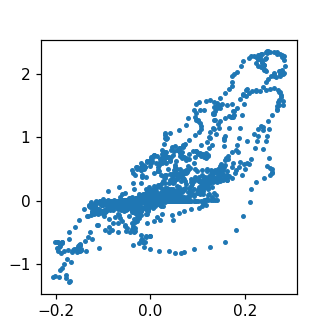

In [642]:
fig, ax= plt.subplots(figsize=(3,3))


ax.scatter(fd_ice_se, ds3.se, s=5)

In [558]:
z = -10
del_u = u_sfc #- ds.u.sel(depth = z) #- u_sfc
del_v = v_sfc #- ds.v.sel(depth = z) #- v_sfc
V = np.sqrt(del_u**2 + del_v**2)

uK = np.sqrt(0.0104 * V ** (1.78))

Text(0, 0.5, '$u_{*0}$')

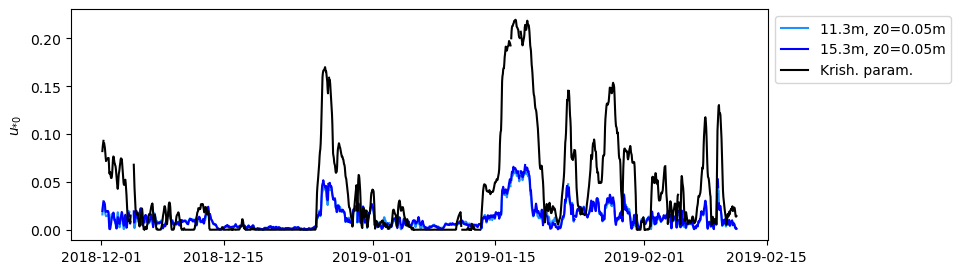

In [559]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9,3))

# plt.plot(ds.time, us0[0.05][-30], label='30m, z0=0.05m', c='lightgray')
plt.plot(ds.time, us0[0.05][-10], label='11.3m, z0=0.05m', c='dodgerblue', )
plt.plot(ds.time, us0[0.05][-12], label='15.3m, z0=0.05m', c='blue', )

plt.plot(ds.time, uK, label='Krish. param.', c='k', )


# plt.plot(ds.time, us0[0.05][-6], label='6m, z0=0.05m', c='darkorange', alpha=0.75)

# ax.set_xlim(datetime(2017,12,1), datetime(2018,4,15))

plt.legend(bbox_to_anchor=(1,1))

plt.ylabel('$u_{*0}$')
# fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


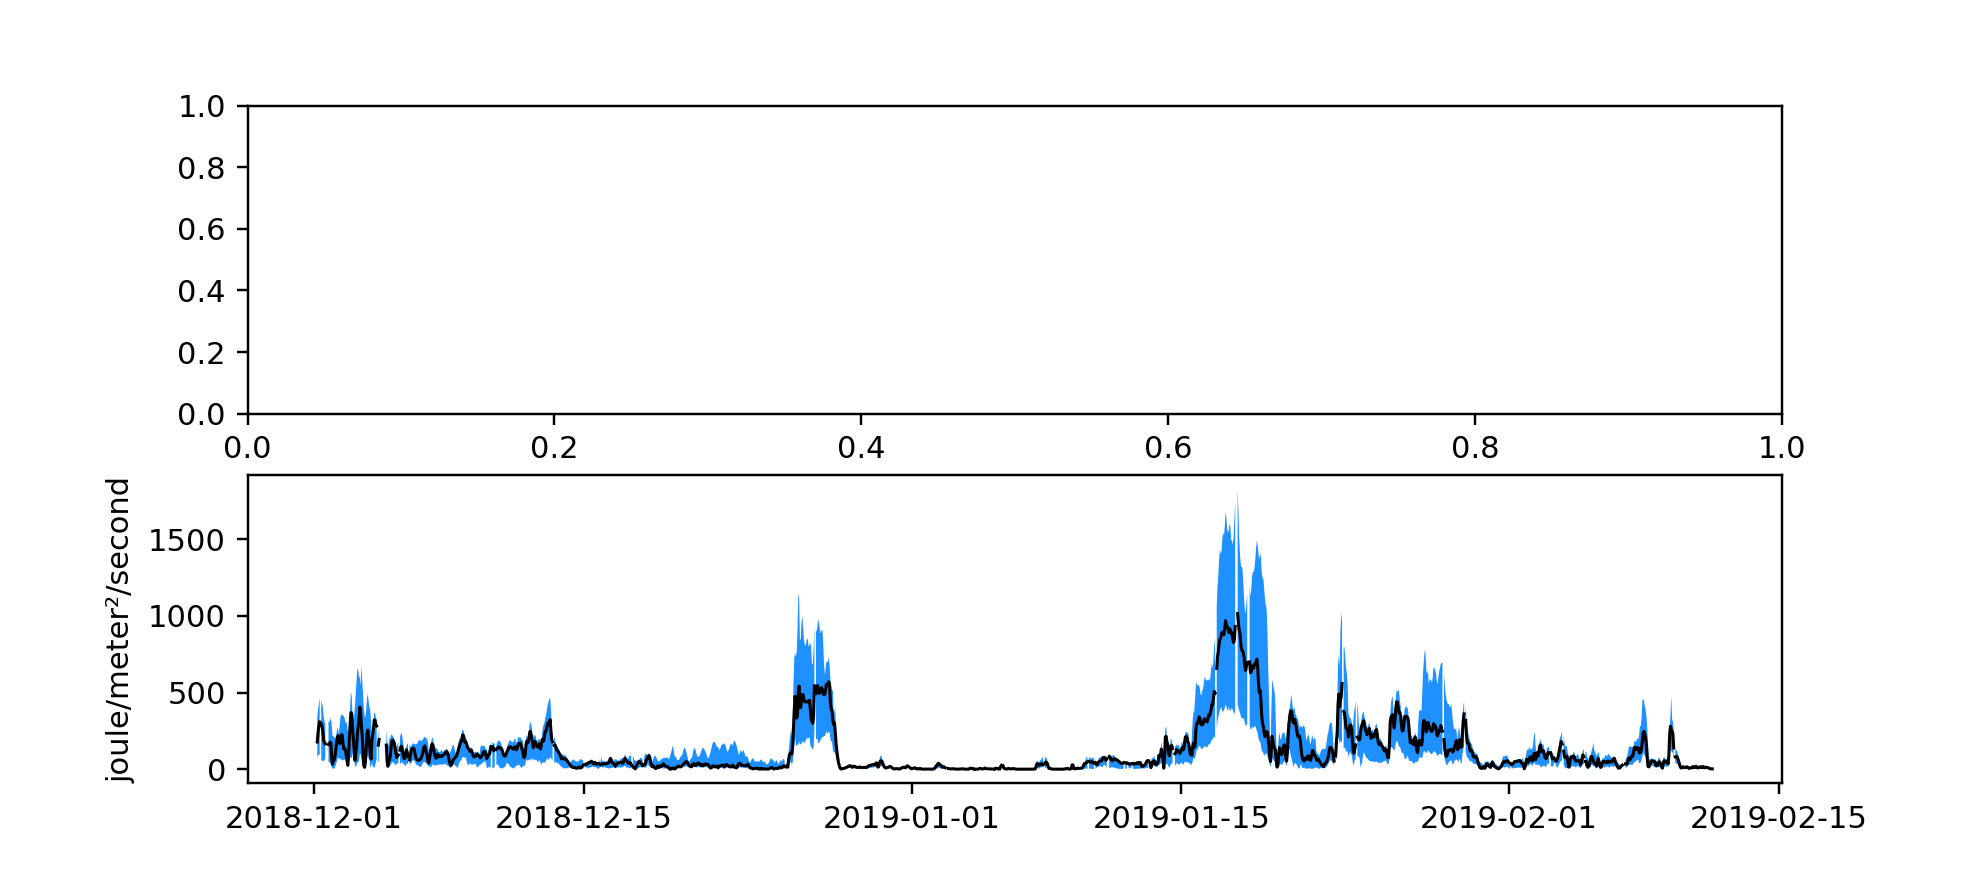

In [533]:
%matplotlib notebook
fig, axs = plt.subplots(2,1,figsize=(9,4))

plt.fill_between(ds.time, THF_min, THF_max, color='dodgerblue', lw=0)
plt.plot(ds.time, THF, c='k', lw=1)

<IPython.core.display.Javascript object>


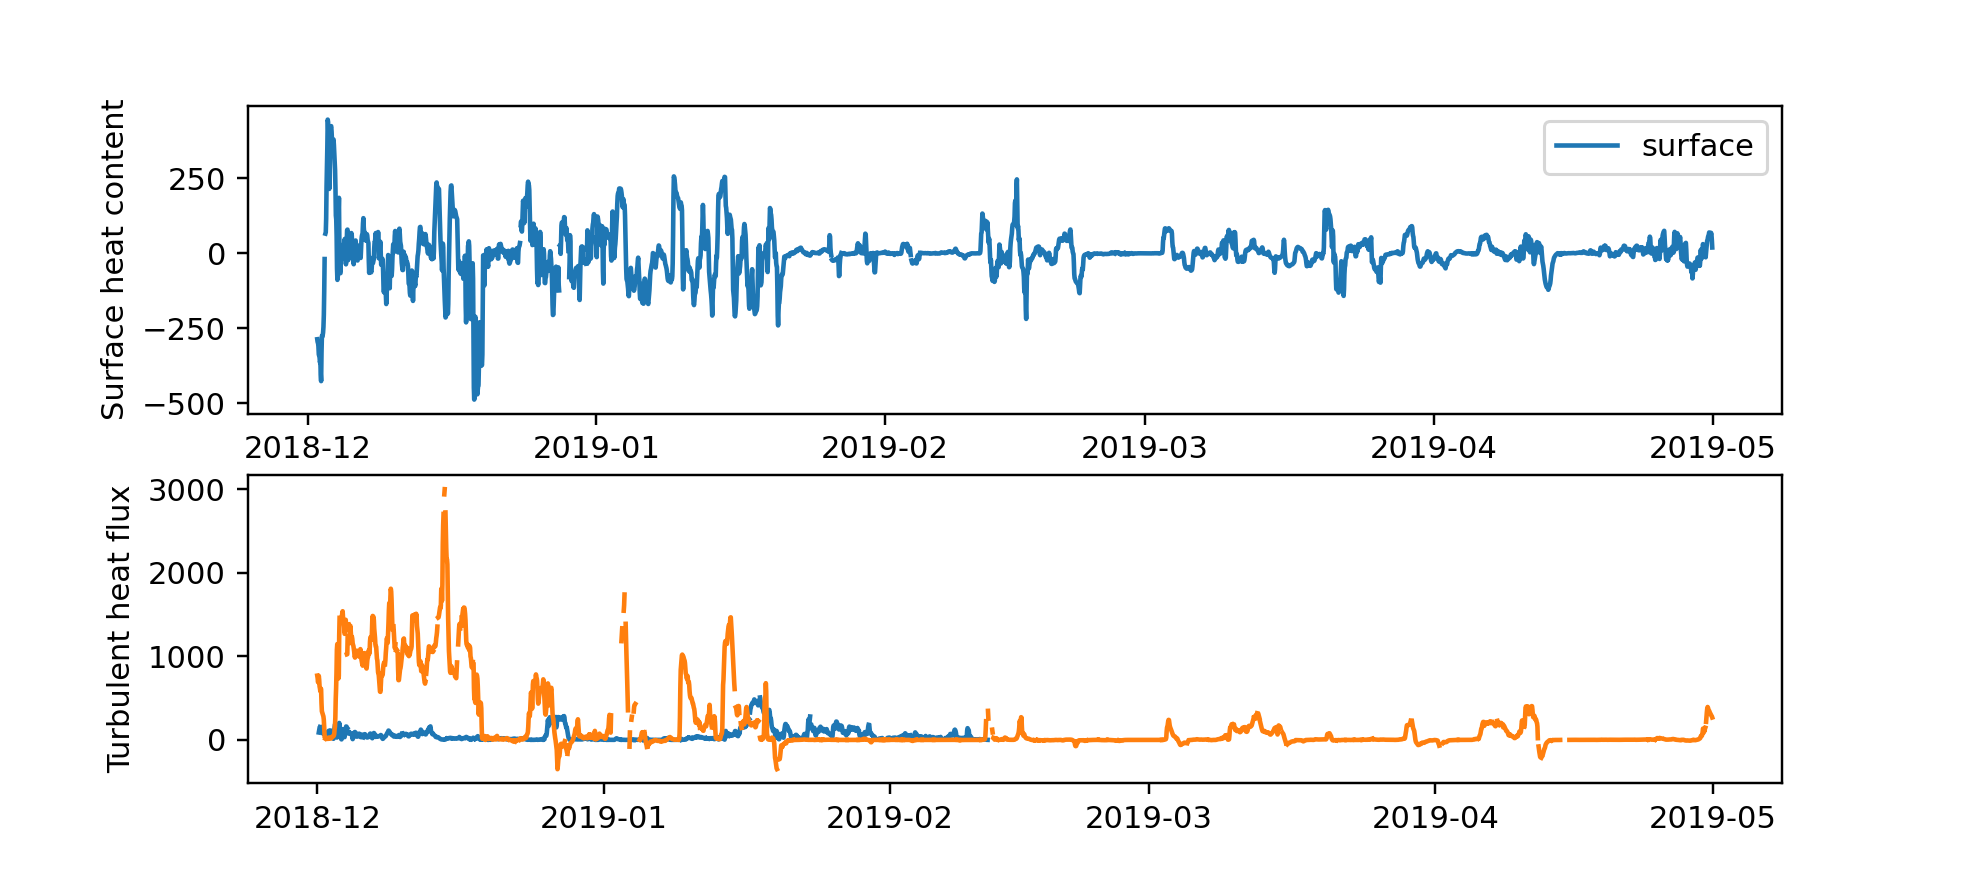

In [532]:
St = 0.0057

zT = -16

dT = (ds2.sel(depth=zT).dT).values * units('delta_degC')

us = us0[0.05][-10] * units('m/s')
THF = (cst['rho_o'] * cst['Cp_o'] * cst['St'] * us * dT)



THF_min = np.copy(THF)
THF_max = np.copy(THF)

for z in z_vals:
    
    for z0 in z0_vals:

        us = us0[z0][z] * units('m/s')
        THF_new = (cst['rho_o'] * cst['Cp_o'] * cst['St'] * us * dT)
        THF_min[THF_new<THF_min] = THF_new[THF_new<THF_min]
        THF_max[THF_new>THF_max] = THF_new[THF_new>THF_max]



%matplotlib notebook
fig, axs = plt.subplots(2,1,figsize=(9,4))

ax = axs[0]
# ax.plot(ds2.time, OHC[0,:])
lag = 24
ax.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(lag*60*60), label = 'surface')
ax.legend()
ax.set_ylabel('Surface heat content')


ax = axs[1]
# ax.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(lag*60*60*units('s')))
ax.plot(ds2.time, 0.5*THF)
ax.set_ylabel('Turbulent heat flux')

ax.plot(ds2.time, (1/3600)*trap_OHT/(16*units('m')))



In [1646]:
wind_angle = vectors.vector_angle(ds4.u10.values, ds4.v10.values)
wind_speed = np.sqrt(ds4.u10.values**2 + ds4.v10.values**2)



wf = 0.15
ta = 20*units('deg')

exp_ice_u = wf * wind_speed * np.cos(wind_angle + ta)
exp_ice_v = wf * wind_speed * np.sin(wind_angle + ta)

exp_ice_se = vectors.comp_along_theta(exp_ice_u, exp_ice_v, 135*units('deg'))





In [1652]:
# 0.2*wind_speed

<IPython.core.display.Javascript object>


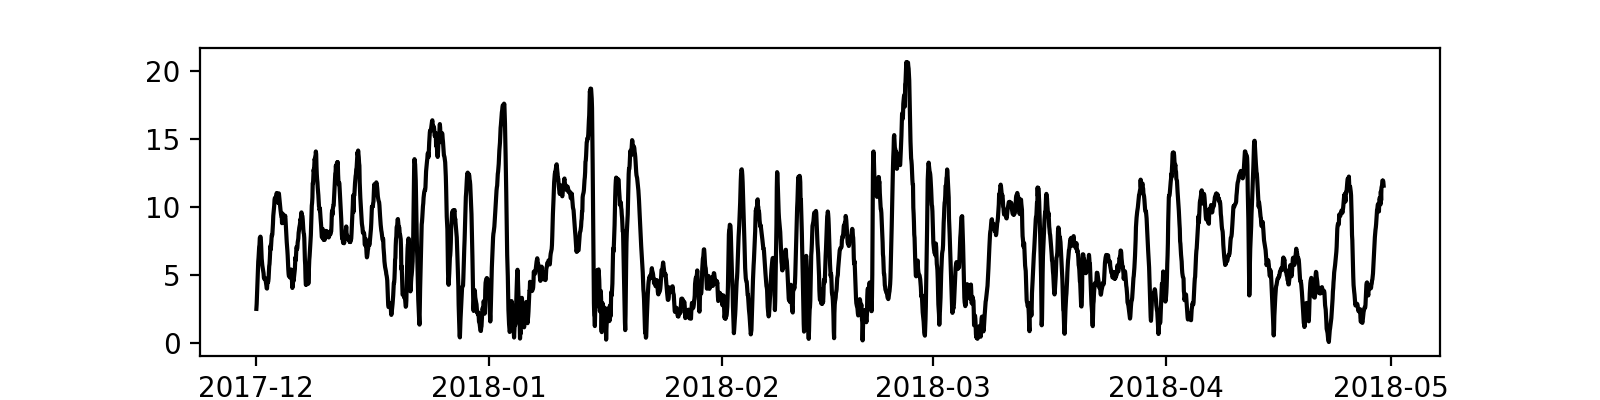

In [1660]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

plt.plot(ds.time, wind_speed, c='k', label='wind')

In [1664]:
2 * (1/0.02)

100.0

<IPython.core.display.Javascript object>


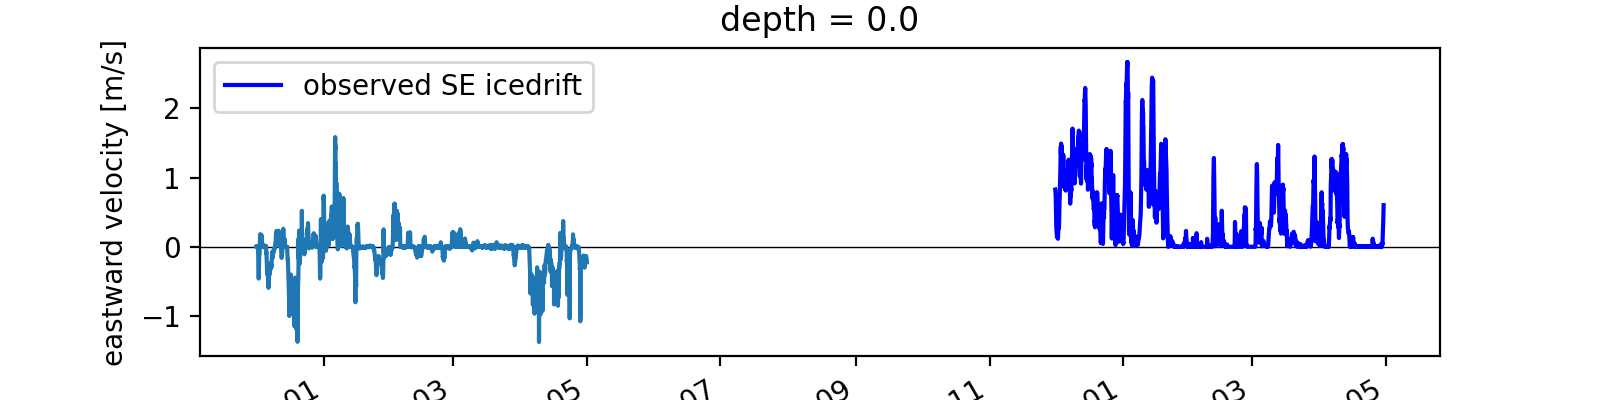

In [1661]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

# plt.plot(ds.time, wind_speed, c='k', label='wind')

# plt.plot(ds.time, exp_ice_se, c='gray', label='expected SE ice drift (wind)')
# plt.plot(ds.time, ma.masked_where(wind_speed<3,np.sqrt(ds3.u**2+ds3.v**2)/wind_speed), c='b', label= 'observed SE icedrift')

plt.plot(ds.time, np.sqrt(ds3.u**2+ds3.v**2), c='b', label= 'observed SE icedrift')

plt.legend()
plt.axhline(0, c='k', zorder=-1, lw=0.5)

# ax2 = ax.twinx()
# ax2.plot(ds2.T.sel(depth=-16), c='r')
# plt.plot(ds4.se)

<IPython.core.display.Javascript object>


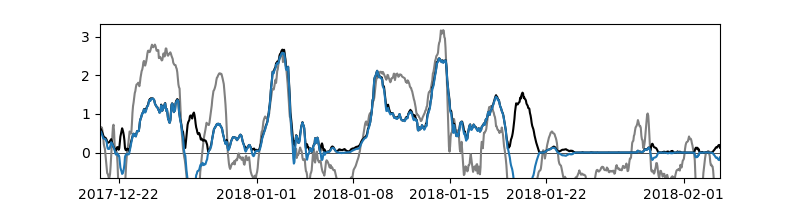

In [1520]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

ax.axhline(0,c='k', zorder=-1, lw=0.5)

# ax.set_xlim(datetime(2017,12,1), datetime(2018,3,1))

# plt.plot(ds.time, 0.2*np.sqrt(ds4.u10**2+ds4.v10**2), c='gray')
plt.plot(ds.time, exp_ice, c='gray')

# plt.plot(ds.time, 0.15*ds4.se_rot20, c='lightgray')
plt.plot(ds.time, np.sqrt(ds3.u**2+ds3.v**2), c='k')

plt.plot(ds.time, ds3.se)

# plt.plot(ds.time, ds.se.sel(depth=-10), c='blue')
# plt.plot(ds.time, icespeed, c='k')




# ds2.dT.sel(depth=-16).plot()
# plt.plot(ds.time[td:], (ds2.dT.sel(depth=-16)[td:]).values-(ds2.dT.sel(depth=-16)[:-td]).values)



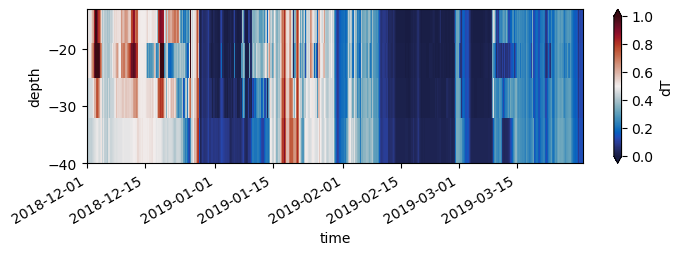

In [1464]:

fig, ax = plt.subplots(figsize=(8,2))

ds2.dT.plot(vmin=0, vmax=1, cmap=cmocean.cm.balance)

In [1440]:
ds2.dT.plot()

In [1404]:
ds2.sel(depth=-16).Ct

<xarray.DataArray 'Ct' (time: 3601)>
[3601 values with dtype=float64]
Coordinates:
    depth    float64 -16.0
  * time     (time) datetime64[ns] 2017-12-01 2017-12-01T01:00:00 ... 2018-04-30
Attributes:
    long_name:  Conservative temperature
    units:      degC

In [1380]:
trap_OHT

<Quantity([22287670.19561567 21728675.68262421 21122584.83847924 ...
  2000277.97990832  3259400.32654066  4518469.92499136], 'joule / meter / second')>